Project: **Exploration Of Vulnerability Dataset Using Machine Learning**


# Imports

In [ ]:
!pip install kneed
!pip install pyLDAvis
import warnings
warnings.filterwarnings('ignore')

import nltk, re, time, os, spacy, gensim, pyLDAvis, pyLDAvis.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import multiprocessing as mp
import tensorflow as tf

from collections import Counter

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.initializers import *

from pprint import pprint
from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback

from kneed import KneeLocator
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 10.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=10f96b6910cc4ccc9e0bb9d5bb5ed2bc9976b85bd7e424243b68cc12c8f0a910
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=d6eed3dc58387e8cddf1c0b000d32bc42a61bd59538af2166b9c4bdf8c01a9a5
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Functions

In [ ]:
def tokenize_only(text):
  # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
  tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
  filtered_tokens = []
  # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
  for token in tokens:
    if re.search('[a-zA-Z]', token):
      filtered_tokens.append(token)
  return filtered_tokens

def tokenize_and_stem(text):
  # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
  tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
  filtered_tokens = []
  # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
  for token in tokens:
    if re.search('[a-zA-Z]', token):
      filtered_tokens.append(token)
  stems = [stemmer.stem(t) for t in filtered_tokens]
  return stems 

# Plot Results
def plot_results(all_history):
  loss, val_loss, accuracy, val_accuracy = [], [], [], []
  for history in all_history:
    loss += history.history['loss']
    val_loss += history.history['val_loss']
    accuracy += history.history['accuracy']
    val_accuracy += history.history['val_accuracy']

  fig, ax = plt.subplots()
  ax.plot(accuracy,label = 'train')
  ax.plot(val_accuracy,label = 'test')
  ax.set_title('Accuracy')
  ax.legend(loc='lower right')
  fig, ax = plt.subplots()
  ax.plot(loss,label = 'train')
  ax.plot(val_loss,label = 'test')
  ax.set_title('Loss')
  ax.legend(loc='upper right')

# Dense Model
def dense_model(inputs = 784,hidden_1=500, hidden_2=500, class_size=10): # CIFAR: inputs 3072
  model = tf.keras.models.Sequential()
  model.add(Dense(hidden_1, input_shape=(inputs,), activation='relu'))
  model.add(Dense(hidden_2, activation='relu'))
  model.add(Dense(class_size, activation='softmax'))
  return model

# VGG 1-5
def vgg_1_5(vgg_num=1, input_shape=(32,32,3), class_size=10):
  print('** Running VGG'+(str(vgg_num))+' ***')
  model = tf.keras.models.Sequential()
  
  x,vg = 32,1
  while x<=512 and vg<=vgg_num:
    model.add(Conv2D(x, kernel_size=(3, 3), input_shape=input_shape, padding='same', activation="relu"))
    model.add(Conv2D(x, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    x, vg = x*2, vg+1

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(class_size, activation='softmax'))
  return model

# Stage 1 - Analyzing Data

At this stage, we perform the following operations: 

1.   Load the vulnerability dataset and obtain vulnerability text descriptions. 
2.   Cluster the data using KMeans
3.   Find topics within the data using LDA



## Load Dataset

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# attach files from google drive
dataset_path = '/content/drive/MyDrive/Datasets/'
# dataset_path = 'https://drive.google.com/drive/folders/1zPdYZlHVaumHyVjcYCypwfsIgaWzBpGt?usp=sharing'
df = pd.read_csv(dataset_path + 'cyvia_dataset_10-20-21.csv', encoding = "ISO-8859-1")
df.head()

,_id,lang,cwe_id,cwe_desc,cwe_plat,cwe_af_res,cwe_consequences,cwe_mitigations,severity,cvss_v2,cvss_v3,vul_access_vector,user_int_req,os,sw,ports,published_date,modified_date,description,url_and_tags
0,CVE-1999-0001,en,CWE-20,Improper Input Validation,::LANGUAGE CLASS:Language-Independent:LANGUAGE...,NaN,"{""Availability"": {""IMPACT"": [""DoS: Crash, Exit...","{""Architecture and Design"": {""STRATEGY"": [""Att...",MEDIUM,5.0,-1.0,NETWORK,False,[],[],[],1999-12-30T05:00Z,2010-12-16T05:00Z,ip_input.c in BSD-derived TCP/IP implementatio...,{'URL0': 'http://www.openbsd.org/errata23.html...
1,CVE-1999-0002,en,CWE-119,Improper Restriction of Operations within the ...,::LANGUAGE NAME:C:LANGUAGE PREVALENCE:Often::L...,::Memory::,"{""Integrity"": {""SCOPE"": [""Confidentiality"", ""A...","{""Requirements"": {""STRATEGY"": [""Language Selec...",HIGH,10.0,-1.0,NETWORK,False,[],[],[],1998-10-12T04:00Z,2009-01-26T05:00Z,Buffer overflow in NFS mountd gives root acces...,{'URL0': 'http://www.securityfocus.com/bid/121...
2,CVE-1999-0003,en,NVD-CWE-Other,NaN,NaN,NaN,{},{},HIGH,10.0,-1.0,NETWORK,False,[],[],[],1998-04-01T05:00Z,2018-10-30T16:26Z,Execute commands as root via buffer overflow i...,{'URL0': 'ftp://patches.sgi.com/support/free/s...
3,CVE-1999-0004,en,NVD-CWE-Other,NaN,NaN,NaN,{},{},MEDIUM,5.0,-1.0,NETWORK,False,[],[],[],1997-12-16T05:00Z,2018-10-12T21:29Z,"MIME buffer overflow in email clients, e.g. So...",{'URL0': 'https://docs.microsoft.com/en-us/sec...
4,CVE-1999-0005,en,NVD-CWE-Other,NaN,NaN,NaN,{},{},HIGH,10.0,-1.0,NETWORK,False,[],[],[],1998-07-20T04:00Z,2008-09-09T12:33Z,Arbitrary command execution via IMAP buffer ov...,{'URL0': 'http://sunsolve.sun.com/pub-cgi/retr...


In [ ]:
print(df.info())
print('\nOriginal DF:', df.shape)
print('Rows:', len(df))
print('Columns:', len(df.columns))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172288 entries, 0 to 172287
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   _id                172288 non-null  object 
 1   lang               162173 non-null  object 
 2   cwe_id             172288 non-null  object 
 3   cwe_desc           122775 non-null  object 
 4   cwe_plat           118636 non-null  object 
 5   cwe_af_res         29489 non-null   object 
 6   cwe_consequences   172288 non-null  object 
 7   cwe_mitigations    172288 non-null  object 
 8   severity           162081 non-null  object 
 9   cvss_v2            172288 non-null  float64
 10  cvss_v3            172288 non-null  float64
 11  vul_access_vector  162081 non-null  object 
 12  user_int_req       161056 non-null  object 
 13  os                 172288 non-null  object 
 14  sw                 172288 non-null  object 
 15  ports              172288 non-null  object 
 16  pu

## Method 1 - Clustering

To determine the optimal number of clusters, we have to select the value of k at the “elbow” i.e. the point after which the distortion/inertia start decreasing in a linear fashion.

KneeLocator Documentation: https://kneed.readthedocs.io/en/stable/parameters.html#curve

In [ ]:
# Preprocessing

# create documents
documents = df['description'].tolist()
print('Total Desciption docs:', len(documents))
print('Difference between df descriptions and descriptions list (documents):', len(df) - len(documents))
# print(documents[0])
print('Longest description found at index:', documents.index(max(documents, key=len)))

longest_description_length = len(max(documents, key=len))
print('Longest description length:', longest_description_length)

print('\nLongest description:\n', max(documents, key=len))

Total Desciption docs: 172288
Difference between df descriptions and descriptions list (documents): 0
Longest description found at index: 152713
Longest description length: 3835

Longest description:
 A vulnerability has been identified in Development/Evaluation Kits for PROFINET IO: DK Standard Ethernet Controller (All versions), Development/Evaluation Kits for PROFINET IO: EK-ERTEC 200 (All versions), Development/Evaluation Kits for PROFINET IO: EK-ERTEC 200P (All versions < V4.7), RUGGEDCOM RM1224 (All Versions < V6.4), SCALANCE M-800 (All Versions < V6.4), SCALANCE S615 (All Versions < V6.4), SCALANCE W1700 IEEE 802.11ac (All versions), SCALANCE W700 IEEE 802.11n (All versions), SCALANCE X200-4 P IRT (All Versions < V5.5.0), SCALANCE X201-3P IRT (All Versions < V5.5.0), SCALANCE X201-3P IRT PRO (All Versions < V5.5.0), SCALANCE X202-2 IRT (All Versions < V5.5.0), SCALANCE X202-2P IRT (incl. SIPLUS NET variant) (All Versions < V5.5.0), SCALANCE X202-2P IRT PRO (All Versions < V5.5.0

In [ ]:
# create feature vectors
start = time.time()
# vectorizer = TfidfVectorizer(stop_words='english')
vectorizer = TfidfVectorizer(stop_words='english', tokenizer=tokenize_only) # , tokenizer=tokenize_and_stem, ngram_range=(1,3)
features = vectorizer.fit_transform(documents)
print('Document Features:', features.shape)

terms = vectorizer.get_feature_names()
print('Total Terms:', len(terms))
print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

Document Features: (172288, 209298)
Total Terms: 209298
Elapsed time = 65.0409 secs


In [ ]:
cluster_range = range(2, 21)
# print(list(cluster_range))

def find_optimal_clusters(k):
  model = KMeans(n_clusters=k, max_iter=100)
  model.fit(features)
  return k, model

# Find optimal clusters from 2-20 clusters
start = time.time()
print('Available CPUs:', mp.cpu_count())
pool = mp.Pool(mp.cpu_count()) # take all available cpus

# Try to find optimal clusters within the given cluster range
results = pool.map(find_optimal_clusters, [k for k in cluster_range])
pool.close()

print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

Available CPUs: 4
Elapsed time = 719.1081 secs


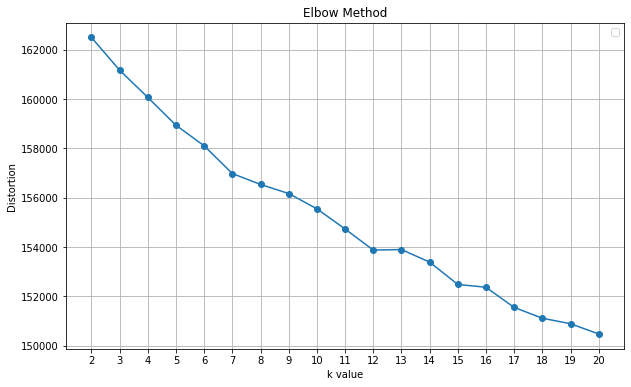

Potential best k: 20
Verify from the graph as well!
Elapsed time = 0.1823 secs


In [ ]:
start = time.time()
# Get sum of squared errors
sse = [s[1].inertia_ for s in results]

# Plot
f, ax = plt.subplots(figsize=(10, 6))
ax.plot(cluster_range, sse, marker='o')
ax.set_xlabel('k value')
ax.set_xticks(cluster_range)
ax.set_xticklabels(cluster_range)
ax.set_ylabel('Distortion')
ax.set_title('Elbow Method')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.grid()
plt.show()

# Locate Knee
kl = KneeLocator(cluster_range, sse, curve="concave", direction="decreasing") # curve="convex"
best_k = kl.elbow 
print('Potential best k:', best_k)
print('Verify from the graph as well!')

print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

Now that we know the optimal number of clusters, we will proceed with clustering our dataset using KMeans algorithm and various parameters.

In [ ]:
optimal_k = 16
start = time.time()
model = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=200) 
model.fit(features)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(optimal_k):
  print("Cluster %d:" % i, end=' '),
  for ind in order_centroids[i, :10]:
    print('%s' % terms[ind], end=' ')
  print()

print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

Cluster 0: candidate consultids reason reject notes cna number use pool assigned 
Cluster 1: microsoft vulnerability memory aka explorer snapdragon internet elevation corruption unique 
Cluster 2: oracle affect unspecified vectors unknown related component integrity confidentiality vulnerability 
Cluster 3: denial service cause crash attackers allows remote crafted possibly memory 
Cluster 4: script inject html scripting cross-site xss web arbitrary remote attackers 
Cluster 5: windows sp2 server r2 sp1 gold microsoft aka vista rt 
Cluster 6: attacker affected exploit issue vulnerability cisco device crafted prior allow 
Cluster 7: ibm x-force id vulnerable altering embed trusted ui allow attacker 
Cluster 8: earlier exploitation adobe lead successful versions acrobat reader execution vulnerability 
Cluster 9: candidate associate individual requested did cna reason reject consultids notes 
Cluster 10: servers certificate x.509 ssl certificates man-in-the-middle spoof verify android obt

In [ ]:
# result = pd.concat([df, pd.DataFrame(features.toarray(),columns=vectorizer_cv.get_feature_names())], axis=1)
x = model.predict(features)
df_cluster = pd.DataFrame(data = x, columns = ['Cluster'])
clustered_df = pd.concat([df, df_cluster], axis=1)

# check nan values
# print(df_cluster[df_cluster.isnull().any(axis=1)])

print(len(df), len(df_cluster))
clustered_df.head()

172288 172288


,_id,lang,cwe_id,cwe_desc,cwe_plat,cwe_af_res,cwe_consequences,cwe_mitigations,severity,cvss_v2,...,vul_access_vector,user_int_req,os,sw,ports,published_date,modified_date,description,url_and_tags,Cluster
0,CVE-1999-0001,en,CWE-20,Improper Input Validation,::LANGUAGE CLASS:Language-Independent:LANGUAGE...,NaN,"{""Availability"": {""IMPACT"": [""DoS: Crash, Exit...","{""Architecture and Design"": {""STRATEGY"": [""Att...",MEDIUM,5.0,...,NETWORK,False,[],[],[],1999-12-30T05:00Z,2010-12-16T05:00Z,ip_input.c in BSD-derived TCP/IP implementatio...,{'URL0': 'http://www.openbsd.org/errata23.html...,3
1,CVE-1999-0002,en,CWE-119,Improper Restriction of Operations within the ...,::LANGUAGE NAME:C:LANGUAGE PREVALENCE:Often::L...,::Memory::,"{""Integrity"": {""SCOPE"": [""Confidentiality"", ""A...","{""Requirements"": {""STRATEGY"": [""Language Selec...",HIGH,10.0,...,NETWORK,False,[],[],[],1998-10-12T04:00Z,2009-01-26T05:00Z,Buffer overflow in NFS mountd gives root acces...,{'URL0': 'http://www.securityfocus.com/bid/121...,15
2,CVE-1999-0003,en,NVD-CWE-Other,NaN,NaN,NaN,{},{},HIGH,10.0,...,NETWORK,False,[],[],[],1998-04-01T05:00Z,2018-10-30T16:26Z,Execute commands as root via buffer overflow i...,{'URL0': 'ftp://patches.sgi.com/support/free/s...,15
3,CVE-1999-0004,en,NVD-CWE-Other,NaN,NaN,NaN,{},{},MEDIUM,5.0,...,NETWORK,False,[],[],[],1997-12-16T05:00Z,2018-10-12T21:29Z,"MIME buffer overflow in email clients, e.g. So...",{'URL0': 'https://docs.microsoft.com/en-us/sec...,15
4,CVE-1999-0005,en,NVD-CWE-Other,NaN,NaN,NaN,{},{},HIGH,10.0,...,NETWORK,False,[],[],[],1998-07-20T04:00Z,2008-09-09T12:33Z,Arbitrary command execution via IMAP buffer ov...,{'URL0': 'http://sunsolve.sun.com/pub-cgi/retr...,15


In [ ]:
# export clustered dataframe to CSV
clustered_df.to_csv(os.path.join(dataset_path,'clustered_cves_dataset.csv'),index=False)

In [ ]:
# Test and classify new documents
examples = [
    "ip_input.c in BSD-derived TCP/IP implementations allows remote attackers to cause a denial of service (crash or hang) via crafted packets.",
    "Buffer overflow in NFS mountd gives root access to remote attackers, mostly in Linux systems.",
    'Denial of Service vulnerability in BIND 8 Releases via maliciously formatted DNS messages.',
    'Telnet allows a remote client to specify environment variables including LD_LIBRARY_PATH, allowing an attacker to bypass the normal system libraries and gain root access.'
]
for example in examples:
    e = vectorizer.transform([example])
    predicted = model.predict(e)
    print("Predicted cluster:", predicted)

Predicted cluster: [3]
Predicted cluster: [15]
Predicted cluster: [3]
Predicted cluster: [15]


In [ ]:
# Randomly select 100 samples from each cluster
sample_size = 100
cluster_samples_df = df.groupby('Cluster').apply(pd.DataFrame.sample, n=sample_size).reset_index(drop=True)
print(cluster_samples_df.shape)

# Export data file.
print('Exporting sample data...', end=' ')
cluster_samples_df.to_csv(os.path.join(dataset_path,'cluster_samples_cve_dataset.csv'), index=False)
print('Done. cluster_samples_cve_dataset.csv')

KeyError: ignored

## Method 2 - Topic Modeling using Latent Dirichlet Allocation (LDA)

In [ ]:
# Preprocessing
start = time.time()

count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english', lowercase=True)
doc_term_matrix = count_vect.fit_transform(df['description'].values.astype('U'))
# print(doc_term_matrix)

print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

In [ ]:
# GridSearch the best LDA model
start = time.time()

search_params = {'n_components': [10, 15, 20], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(doc_term_matrix)

print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

In [ ]:
start = time.time()
GridSearchCV(error_score='raise', estimator=LatentDirichletAllocation(), n_jobs=1, 
  param_grid={'n_topics': [10, 15, 20], 'learning_decay': [0.5, 0.7, 0.9]},
  pre_dispatch='2*n_jobs', refit=True, return_train_score='warn', scoring=None, verbose=0)

print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

In [ ]:
start = time.time()
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_term_matrix))
print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

In [ ]:
# Use best LDA on document dataset
start = time.time()
#LDA = LatentDirichletAllocation(n_components=10, max_iter=10, random_state=42, batch_size=128, n_jobs = -1) # 16 clusters -> 16 topics
best_lda_model.fit(doc_term_matrix)
print('Elapsed time = {:.4f} secs'.format(time.time() - start))

In [ ]:
# Let's print the 10 words with highest probabilities for all the five topics:
# for i,topic in enumerate(LDA.components_):
for i,topic in enumerate(best_lda_model.components_):
  print(f'Top 10 words for topic #{i}:', [count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])

In [ ]:
# assign the probability of all the topics to each document
start = time.time()
# topic_values = LDA.transform(doc_term_matrix)
topic_values = best_lda_model.transform(doc_term_matrix)
print(topic_values.shape)
# print(topic_values)
print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

In [ ]:
# Add topic column to the dataframe
df['Topic'] = topic_values.argmax(axis=1)
df.head()

In [ ]:
# Test and classify new documents
examples = [
    "ip_input.c in BSD-derived TCP/IP implementations allows remote attackers to cause a denial of service (crash or hang) via crafted packets.",
    "Buffer overflow in NFS mountd gives root access to remote attackers, mostly in Linux systems.",
    'Denial of Service vulnerability in BIND 8 Releases via maliciously formatted DNS messages.',
    'Telnet allows a remote client to specify environment variables including LD_LIBRARY_PATH, allowing an attacker to bypass the normal system libraries and gain root access.'
]

for example in examples:
    e = count_vect.transform([example])
    predicted = best_lda_model.transform(e)
    topic = df[['Topic']].iloc[np.argmax(predicted), :].values.tolist()
    print("Predicted topic:", topic)

In [ ]:
# export topics dataframe
df.to_csv(os.path.join(dataset_path,'topics_cves_dataset.csv'), index=False)

## Conclusion Stage 1

At this point, we have a clustered dataset using KMeans and a topics dataset with found topics using LDA. We have used the Elbow method to determine the optimum number of clusters and GridSearch for LDA to find the best number of topics. 

Vulnerability dataset contained 172,287 documents. 882.7558 secs

*   KMeans took 882.7558 secs seconds to find the best k (2-20) with max_iter=100.
*   LDA took approximately 8 hours to perform the GridSearch to find the best topic model using parameters 'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9].

We export these datasets and manually label random documents to try different classification algorithms in the following stages.

# Stage 2 - Labeling

We have manually labeled 100 random samples from each cluster and will be evaluating different classification algorithms in the next stage.

**Note**: After labeling the cluster samples, we were able to find 22 different classes (Types of Attacks) from the vulnerability documents. We use this data as the training and test data for our project. Although we have used LDA, but the clustered data produced by kmeans clusters seemed more segmented and after manual labeling, we gained more confidence on the dataset with 22 target classes. 


# Stage 3 - Classification

At this stage, we perform the following operations: 

1.   Load the labeled dataset, preprocess, and split into training and testing sets. 
2.   Use various classification algorithms with different parameters to see which one performs better.
3.   Improvement ideas.
4.   Word Embedding.

## Load Datasets

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount("/content/drive")

# attach files from google drive
dataset_path = '/content/drive/MyDrive/Datasets/'

In [ ]:
# Import the labeled file
df_labeled_data = pd.read_excel(dataset_path + 'clustered_dataset.xlsx') # , encoding = "ISO-8859-1"
print('Original dataset shate:', df_labeled_data.shape)

# drop not needed columns
df_labeled_data = df_labeled_data.drop(['lang','cwe_id','cwe_desc','cwe_plat','cwe_af_res','cwe_consequences','cwe_mitigations','severity','cvss_v2','cvss_v3','vul_access_vector','user_int_req','os','sw','ports','published_date','modified_date','url_and_tags','Cluster'], axis=1)
print('Dataset after trimming:', df_labeled_data.shape)
df_labeled_data.head()

In [ ]:
# Create Label IDs for classifiers to identify target class
df_labeled_data['Label_id'] = df_labeled_data['Label'].factorize()[0]
Label_id_df = df_labeled_data[['Label', 'Label_id']].drop_duplicates().sort_values('Label_id')
Label_to_id = dict(Label_id_df.values)
id_to_Label = dict(Label_id_df[['Label_id', 'Label']].values)

# Show documents 95 - 105
df_labeled_data.iloc[95:105]

In [ ]:
# Check Imbalanced Classes
fig = plt.figure(figsize=(6,3))
df_labeled_data.groupby('Label').Label_id.count().plot.bar(ylim=0)
plt.xlabel("Classes")
plt.ylabel("Examples")
plt.show() 

print('Classes:', len(df_labeled_data['Label'].unique()), '->', df_labeled_data['Label'].unique())

Clearly we can see that we have imbalance classes. ***From 16 clusters, we created 14 classes***.

Reason for keeping classes with low examples is because we have a large unlabelled dataset that we will classify after training the model. So the classifier should have seen at least few examples. 

## Training and Test Split

In [ ]:
# Preprocessing

# Create Feature Vectors
tfidf = TfidfVectorizer(stop_words='english', tokenizer=tokenize_only)
features = tfidf.fit_transform(df_labeled_data.description).toarray()
labels = df_labeled_data.Label_id
print('We have', features.shape[0], 'examples with', features.shape[1],'features.')

In [ ]:
# Split Data Train 70% Test 30%
X, y = features, labels
# when random_state set to an integer, train_test_split will return same results for each execution.
# when random_state set to an None, train_test_split will return different results for each execution.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)
print('X_train:', x_train.shape, 'X_test:', x_test.shape, 'y_train:', y_train.shape, 'y_test:', y_test.shape)
classes = np.max(y)+1
print('Total number of classes:', classes)

## Various Classification Algorithms

In [ ]:
# Evaluate Different Models
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.int` is a deprecated alias for the builtin `int`')

def knn_k_evaluation(x_train, y_train, x_test, y_test, kv=12, a='auto'): 
  # weights{‘uniform’, ‘distance’} or callable, default=’uniform’ # algorithm{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
  knn_acc_list, knn_params = [], [] #
  k_list = np.arange(1, kv, 2) # neighbors 1-12 odd default
  train_time_list, test_time_list = [],[] #

  for k in k_list: # K
    model =  KNeighborsClassifier(n_neighbors=k, algorithm=a, n_jobs=-1) # The number of parallel jobs to run for neighbors search. -1 means using all processors.
    start_train = time.time() #
    model.fit(x_train, y_train)
    end_train = time.time() #
    train_time_list.append(end_train-start_train) #

    start_test = time.time() #
    pred = model.predict(x_test)
    end_test = time.time() #
    test_time_list.append(end_test - start_test) #
    
    knn_params.append('Algorithm = '+a+' with k = '+str(k)) #
    print('Algorithm =', a, ', k =',k, '\t Training = {:.4f} secs'.format(end_train-start_train), ', Testing = {:.4f} secs'.format(end_test-start_test), ', Accuracy = {:.4f}'.format(accuracy_score(y_test, pred)))
    knn_acc_list.append(accuracy_score(pred, y_test))
  
  knn_best = np.argmax(knn_acc_list)
  print('The best results for K-Nearest Neighbors is', knn_params[knn_best], 'and Accuracy = {:6.4f}'.format(knn_acc_list[knn_best]), '\n')
  return knn_acc_list[knn_best]

def decision_tree_depth_evaluation(x_train, y_train, x_test, y_test, dp=15): 
  # splitter{“best”, “random”}, default=”best” # criterion{“gini”, “entropy”}, default=”gini”
  dt_acc_list, dt_params = [], []
  train_time_list, test_time_list = [],[]
  for i in range(1, dp): # check depths from 1-15 default
    model = tree.DecisionTreeClassifier(max_depth=i)
    start_train = time.time()
    model.fit(x_train, y_train)
    end_train = time.time()
    train_time_list.append(end_train-start_train)

    start_test = time.time()
    pred = model.predict(x_test)
    end_test = time.time()
    test_time_list.append(end_test - start_test)

    dt_acc_list.append(accuracy_score(y_test, pred))
    dt_params.append('Depth = '+str(i))
    print('Depth =', i, '\t Training = {:.4f} secs'.format(end_train-start_train), ', Testing = {:.4f} secs'.format(end_test-start_test), ', Accuracy = {:.4f}'.format(accuracy_score(y_test, pred)))

  dt_best = np.argmax(dt_acc_list)
  print('The best depth in DecionTree is', dt_params[dt_best], 'with Accuracy = {:6.4f}'.format(dt_acc_list[dt_best]), '\n')
  return dt_acc_list[dt_best]

def evaluate_model(model, model_name, x_train, y_train, x_test, y_test):
  if model_name=='K-Nearest Neighbors':
    return knn_k_evaluation(x_train, y_train, x_test, y_test) # you can pass k value e.g. kv=10 and algorithm e.g. a='auto'
  if model_name=='Decision Tree':
    return decision_tree_depth_evaluation(x_train, y_train, x_test, y_test) # you can pass depth value e.g dp=20
  if model_name=='Gaussian Naive Bayes':
    m = model(var_smoothing=1e-09)
    m.fit(x_train, y_train)
    pred = m.predict(x_test)
    return accuracy_score(y_test, pred)    
  else:
    m = model()
    start_train = time.time()
    m.fit(x_train, y_train)
    train_time = time.time() - start_train
    start_test = time.time()
    pred = m.predict(x_test)
    test_time = time.time() - start_test
    print('Model:', m, 'Training = {:.4f} secs'.format(train_time), ', Testing = {:.4f} secs'.format(test_time), ', Accuracy = {:.4f}'.format(accuracy_score(y_test, pred)))
    return accuracy_score(y_test, pred)

start = time.time()

models = [SVC, LinearSVC, KNeighborsClassifier, RandomForestClassifier, MLPClassifier, MultinomialNB, GaussianNB, BernoulliNB, DecisionTreeClassifier]
model_names = ['Support Vector Machine', 'Linear Support Vector Machine', 'K-Nearest Neighbors', 'Random Forest', 'Multilayer Perceptron', 'Multinomial Naive Bayes', 'Gaussian Naive Bayes', 'Bernoulli Naive Bayes', 'Decision Tree']

acc_list = []
for i in range(len(models)):
  print('Evaluating', model_names[i])
  start1 = time.time()
  acc_list.append(evaluate_model(models[i], model_names[i], x_train, y_train, x_test, y_test))
  print(model_names[i], 'Accuracy = {:6.4f}'.format(acc_list[-1]))
  print('Time taken = {:.4f} secs'.format(time.time() - start1), '\n') 

best = np.argmax(acc_list)
print('\nThe best model is', model_names[best], 'with Accuracy = {:6.4f}'.format(acc_list[best]))

print('Total time = {:.4f} secs'.format(time.time() - start))

## Best Classification Algorithm Test

In [ ]:
# Best Model Training
start = time.time()
classifier = LinearSVC()
classifier.fit(x_train, y_train) 
print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

In [ ]:
# Best Model Test
y_pred = classifier.predict(x_test)

In [ ]:
# Best Model Results
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('\nConfusion Matrix:\n', confusion_matrix(y_test,y_pred))
print('\nClassification Report:\n', classification_report(y_test,y_pred))

In [ ]:
print('classes:', y.unique())

def check_class_label(class_id):
  return df_labeled_data.loc[df_labeled_data['Label_id'] == class_id, 'Label'].iloc[0]

print('\nClasses with low/0 precision and recall:')
print(check_class_label(13))
# print(check_class_label(15))
# print(check_class_label(20))
# print(check_class_label(19))

## Improvement Ideas

We can try to improve results using PCA at this point

In [ ]:
# As we know LinearSVC is working better, we can use PCA to improve the results
n_components=300 # 300-84, 

start = time.time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(x_train)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
print(x_train_pca.shape)
# print(y_train.shape)

model = LinearSVC()
model.fit(x_train_pca, y_train)
print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

In [ ]:
pred = model.predict(x_test_pca)
accuracy = accuracy_score(y_test, pred)
print(f'PCA Accuracy {accuracy:.4}')

We can further try to see if Dense network using PCA improves accuracy further.

In [ ]:
# And we can do dense with PCA also
dense_network = dense_model(inputs = x_train_pca.shape[1], class_size=classes)
dense_network.summary() 
dense_network.compile(loss="categorical_crossentropy", metrics=["accuracy"])
all_history = []  

In [ ]:
# one hot 
y_train = tf.keras.utils.to_categorical(y_train, num_classes=classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=classes)

y_test.shape , x_test_pca.shape

In [ ]:
# Dense with PCA
start = time.time()
all_history = []
history = dense_network.fit(
    x_train_pca, y_train,
    epochs =  10, 
    batch_size=16, 
    verbose = 1,
    validation_data=(x_test_pca, y_test),
)

all_history.append(history)

print('Final accuracy on training set: {:.4f}'.format(history.history['accuracy'][-1]))
print('Final accuracy on test set: {:.4f}'.format(history.history['val_accuracy'][-1]))

plot_results(all_history)
print('Elapsed time = {:.4f} secs'.format(time.time() - start))

If we run Dense directly without PCA...

In [ ]:
X, y = features, labels
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, shuffle=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
classes = np.max(y)+1
print('Total number of classes:', classes)

In [ ]:
# one hot 
y_train = tf.keras.utils.to_categorical(y_train, num_classes=classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=classes)
dropout=0.5

# Dense Model - Artificial Neural Network
def dense_model(inputs = 784,hidden_1=1250, hidden_2=1000, class_size=10): # 500-500->0.8422, 1250-1000->0.85
  model = tf.keras.models.Sequential()
  model.add(Dense(hidden_1, input_shape=(inputs,), activation='relu'))
  # model.add(BatchNormalization())
  #model.add(Dropout(dropout))
  model.add(Dense(hidden_2, activation='relu'))
  # model.add(BatchNormalization())
  # model.add(Dropout(dropout))
  # model.add(Dense(hidden_3, activation='relu'))
  model.add(Dense(class_size, activation='softmax'))
  return model

dense_network = dense_model(inputs = x_train.shape[1], class_size=classes)
dense_network.summary() 
dense_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

all_history = []

In [ ]:
# Dense Model - Artificial Neural Network
'''
Initially the accuracy with default param was 82%, after adding adam optimier, reducing batch size to 16 as we have small number 960 of training examples, smaller batch size helps and improves accuracy.
Adding layers not helpful, smaller batch size helpful, batchnormalization and dropout also not helpful.
'''
rop = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=2, verbose=1,min_lr=0.0005)

start = time.time()

history = dense_network.fit(
  x_train, y_train,
  epochs =  10, 
  batch_size=16, 
  verbose = 1,
  validation_data=(x_test, y_test),
  callbacks=[rop]
)

all_history.append(history)

print('Final accuracy on training set: {:.4f}'.format(history.history['accuracy'][-1]))
print('Final accuracy on test set: {:.4f}'.format(history.history['val_accuracy'][-1]))

plot_results(all_history)
print('Elapsed time = {:.4f} secs'.format(time.time() - start))

Although we know VGG is good for image classification, we can still try to classify text documents to see what happens.

In [ ]:
# Reshape data
print(x_train.shape)
x_train_cnn = np.expand_dims(x_train.reshape(x_train.shape[0], 137, 43),-1) # rows, features (two multiples 137*43=5891), additional dimension.
x_test_cnn = np.expand_dims(x_test.reshape(x_test.shape[0],137,43),-1)
print(x_train_cnn.shape, x_test_cnn.shape)

In [ ]:
x_train

In [ ]:
x_train_cnn = np.expand_dims(x_train.reshape(x_train.shape[0],137,43),-1)

In [ ]:
# CNN- General Test (vgg1-vgg5 with different batch sizes)
start = time.time()
rop = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=2, verbose=1,min_lr=0.0005)

models, acc_list=[],[]
for vg in range(1,6):
  cnn = vgg_1_5(vgg_num=vg, input_shape= x_train_cnn.shape[1:], class_size=classes)
  cnn.summary() 
  cnn.compile(loss="categorical_crossentropy", metrics=["accuracy"])

  # print('** Dataset:', dataset_name)

  batch_sz = 16 # Start Batch size from 16 and go up to 256 because we have a small dataset
  while batch_sz <= 256:
    all_history = []
    print('\n** Trying vgg'+str(vg)+' with batch size', batch_sz)
    history = cnn.fit(
      x_train_cnn, y_train,
      epochs =  10, 
      batch_size=batch_sz, 
      verbose = 1,
      callbacks=[rop],
      validation_data=(x_test_cnn, y_test),
    )

    all_history.append(history)

    print('Final accuracy on training set: {:.4f}'.format(history.history['accuracy'][-1]))
    print('Final accuracy on test set: {:.4f}'.format(history.history['val_accuracy'][-1]))
    print('Mean accuracy in last 5 epochs: {:.4f}'.format(np.mean(history.history['val_accuracy'][-5:])))
    models.append('VGG'+str(vg)+' Batch='+str(batch_sz)), acc_list.append(history.history['val_accuracy'][-1])

    plot_results(all_history)
    plt.show()
    batch_sz *= 2
            
best = np.argmax(acc_list)
for i in range(len(models)):
  print('Model', models[i], '\tAccuracy {:.4f}'.format(acc_list[i]))

print('\nThe best model is', models[best], 'with Accuracy = {:6.4f}'.format(acc_list[best]))
print('Elapsed time = {:.4f} secs'.format(time.time() - start))

## Word Embedding

Based on the vulnerability data that we have, we can either learn from the data that we have and create our own Embedding layer or use a pretrained word embeddings.

### Learned Word Embeddings

In [ ]:
from sklearn.model_selection import train_test_split
X, y = features, labels
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
classes = np.max(y)+1
print('Total number of classes:', classes)

In [ ]:
# Random splits
np.random.seed(123)
n = len(df_labeled_data.description)
ind = np.random.permutation(n)

description = df_labeled_data.description.to_numpy()
label = df_labeled_data.Label_id.to_numpy()

x_test = [description[i] for i in ind[:n//4]] # 1/4 75,25 split
x_train = [description[i] for i in ind[n//4:]]
y_test = tf.keras.utils.to_categorical([label[i] for i in ind[:n//4]], classes) # 1/4 75,25 split
y_train = tf.keras.utils.to_categorical([label[i] for i in ind[n//4:]], classes)

In [ ]:
len(x_train), y_train.shape, len(x_test), y_test.shape, len(x_train)

In [ ]:
max_words = 15000
seq_len = 2500 # Average length description
tokenizer = Tokenizer(num_words = max_words)

tokenizer.fit_on_texts(x_train)

x_train_seq0 = tokenizer.texts_to_sequences(x_train)
x_test_seq0 = tokenizer.texts_to_sequences(x_test)

x_train_seq = pad_sequences(x_train_seq0,seq_len,truncating='post')
x_test_seq = pad_sequences(x_test_seq0,seq_len,truncating='post')

In [ ]:
# x_train
x_train_seq.shape, x_test_seq.shape, y_test.shape

In [ ]:
# Remove sequences that have no in-vocabulary words
print(np.sum(np.sum(x_train_seq,axis=1)==0))
print(np.sum(np.sum(x_test_seq,axis=1)==0))

has_valid_words = np.where(np.max(x_train_seq,axis=1)>0)[0]

print(len(has_valid_words))

x_train_seq = x_train_seq[has_valid_words]
x_train = [x_train[i] for i in has_valid_words]
y_train = y_train[has_valid_words]

has_valid_words = np.where(np.max(x_test_seq,axis=1)>0)[0]
x_test_seq = x_test_seq[has_valid_words]
x_test = [x_test[i] for i in has_valid_words]
y_test = y_test[has_valid_words]

print(np.sum(np.sum(x_train_seq,axis=1)==0))
print(np.sum(np.sum(x_test_seq,axis=1)==0))

In [ ]:
word_index = tokenizer.word_index
print('Found {} unique words'.format(len(word_index)))

word_list = ['UNKNOWN' for w in range(len(word_index)+1)]
for w in word_index.keys():
    word_list[word_index[w]] = w

# Most common
print('Most common:', end=' ')
for w in word_list[:20]:
  print(w, end=' ')

# Least common
print('\nLeast common:', end=' ')
for w in word_list[-20:]:
  print(w, end=' ')

In [ ]:
def plot_results(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  fig, ax = plt.subplots()
  ax.plot(accuracy,label = 'train')
  ax.plot(val_accuracy,label = 'test')
  ax.set_title('Accuracy')
  ax.legend(loc='lower right')
  fig, ax = plt.subplots()
  ax.plot(loss,label = 'train')
  ax.plot(val_loss,label = 'test')
  ax.set_title('Loss')
  ax.legend(loc='upper right')
  plt.show()
  
def cnn1D(vocab_size,emb_len=50, seq_len=250, n_classes=3,dropout=0.5,n=128):
  ks = 1 # 1 has the highest 80%, tried 3, 5, 7
  model = tf.keras.models.Sequential()
  model.add(Embedding(vocab_size,emb_len,input_length=seq_len,name='embeddings')) 
  model.add(Conv1D(n, kernel_size = ks, padding='same',activation="relu"))
  model.add(MaxPooling1D(pool_size=8, padding='same'))
  model.add(Dropout(dropout))
  model.add(Conv1D(2*n, kernel_size = ks, padding='same', activation="relu"))
  model.add(MaxPooling1D(pool_size=8, padding='same'))
  model.add(Dropout(dropout))
  # model.add(Conv1D(2*n, kernel_size = ks, padding='same', activation="relu"))
  # model.add(MaxPooling1D(pool_size=8, padding='same'))
  # model.add(Dropout(dropout))
  model.add(Flatten())
  model.add(Dense(n_classes,activation= 'softmax'))
  return model

In [ ]:
rop = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=2, verbose=1)
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)

model = cnn1D(vocab_size = max_words, emb_len=50, seq_len=x_train_seq.shape[1], n=64, n_classes=classes)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(
  x_train_seq, y_train,
  validation_data=(x_test_seq, y_test),
  epochs = 20, 
  verbose = 1,
  batch_size=16,
  callbacks = [rop, es]
)
acc = history.history['val_accuracy']
print('max accuracy = {:.4f} in epoch {}, final accuracy = {:.4f}'.format(np.amax(acc),np.argmax(acc)+1,acc[-1]))
plot_results(history)

### Pretrained Word Embeddings

We will use stanford pretrained embedding on Wikipedia documents.

In [ ]:
# download a zip file containing word embeddings of lengths 50,100,200, and 300
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [ ]:
# Build a dictionary where embedding[w] contains the embedding of word w with embeddings of length 50.
def read_embeddings(n=1000):
  # Reads n embeddings from file
  # Returns a dictionary were embedding[w] is the embeding of string w
  embedding = {}
  count = 0
  with open('glove.6B.50d.txt', encoding="utf8") as f: 
    for line in f: 
      count+=1
      ls = line.split(" ")
      emb = np.array([np.float32(x) for x in ls[1:]])
      embedding[ls[0]]=emb
      if count>= n:
        break
  return embedding

vocabulary_size = 1000000000        
embedding = read_embeddings(vocabulary_size)

In [ ]:
emb_mat = np.zeros((len(embedding),len(embedding['a'])))
for i, k in enumerate(embedding.keys()):
  emb_mat[i] = embedding[k]

plt.plot(np.mean(emb_mat,axis=0))

In [ ]:
print(np.std(emb_mat))
print(np.mean(emb_mat))

In [ ]:
num_tokens = len(tokenizer.word_index)+1
embedding_dim = len(embedding['a'])
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim)) + np.mean(emb_mat,axis=0,keepdims=True)
#yembedding_matrix = np.random.normal(loc=0.0, scale=0.1, size=(num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():

  embedding_vector = embedding.get(word)
  if embedding_vector is not None:
    # Words not found in embedding index will be all-zeros.
    # This includes the representation for "padding" and "OOV"
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
print(embedding_matrix.shape)

In [ ]:
embedding_layer = Embedding(
  num_tokens,
  embedding_dim,
  embeddings_initializer=Constant(embedding_matrix),
  trainable=True,
)

In [ ]:
def cnn1D(embedding_matrix, seq_len=250, n_classes=3,dropout=0.5,n=128):
  ks = 6 # 6->84.50
  model = tf.keras.models.Sequential()
  model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],input_length=seq_len,name='embeddings',embeddings_initializer=Constant(embedding_matrix),
    trainable=True))
  for i in range(1,3):
    model.add(Conv1D(n*i, kernel_size = ks, padding='same',activation="relu"))
    model.add(Conv1D(n*i, kernel_size = ks, padding='same',activation="relu"))
    model.add(MaxPooling1D(5, padding='same'))
    model.add(Dropout(dropout))

  model.add(Flatten())
  #model.add(Dense(n,activation= 'relu'))
  #model.add(Dropout(dropout/2))
  model.add(Dense(n_classes,activation= 'softmax'))
  return model

In [ ]:
x_train_seq.shape, y_train.shape

In [ ]:
rop = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1)
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=6)

model = cnn1D(embedding_matrix=embedding_matrix, seq_len=seq_len, n=128, n_classes=classes)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model.fit(
  x_train_seq, y_train,
  validation_data=(x_test_seq, y_test),
  epochs = 20, 
  verbose = 1,
  batch_size=16,
  callbacks = [rop, es]
)
acc = history.history['val_accuracy']
print('max accuracy = {:.4f} in epoch {}, final accuracy = {:.4f}'.format(np.amax(acc),np.argmax(acc)+1,acc[-1]))
plot_results(history)

## Conclusion Stage 3

Among the algorithms that we have tried, Linear SVM returned the highest accuracy of 86\%. We have tried to improve the accuracy using PCA, Dense Network, and Also Word Embedding but the accuracy did not improve. We were very hopeful for the Word Embedding model to outperform other models but the results how otherwise. Between the Learned and Pre-Trained Word Embedding models, Pre-Trained produced better results with the trainable parameter set to True. Another observation that changed the result accuracies was the smaller batch size as our labeled dataset is small, batch\_size=16 produced the best results. It was also interesting to see that Deep Neural Networks (VGG1-5) with different parameters produced poor results for text classification. 

# Zero-shot Learning

## Method 1 - Bert

https://analyticsindiamag.com/a-complete-tutorial-on-zero-shot-text-classification/

https://www.sbert.net/index.html

https://scholar.google.com/scholar?hl=en&as_sdt=0%2C44&q=Sentence-BERT%3A+Sentence+Embeddings+using+Siamese+BERT-Networks&btnG=

https://joeddav.github.io/blog/2020/05/29/ZSL.html

https://analyticsindiamag.com/a-complete-tutorial-on-zero-shot-text-classification/

### Load Model

In [7]:
# load the sentence-bert model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install transformers
from transformers import AutoTokenizer, AutoModel
from torch.nn import functional as F
tokenizer = AutoTokenizer.from_pretrained('deepset/sentence_bert')
model = AutoModel.from_pretrained('deepset/sentence_bert')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.0 MB/s 
     |████████████████████████████████| 120 kB 80.2 MB/s 
     |████████████████████████████████| 6.6 MB 68.2 MB/s 


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/sentence_bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Test Example

In [8]:
# sentence = 'Who are you voting for in 2020?'
# labels = ['business', 'art & culture', 'politics']

# # run inputs through model and mean-pool over the sequence
# # dimension to get sequence-level representations
# inputs = tokenizer.batch_encode_plus([sentence] + labels, return_tensors='pt', pad_to_max_length=True)
# input_ids = inputs['input_ids']
# attention_mask = inputs['attention_mask']
# output = model(input_ids, attention_mask=attention_mask)[0]
# sentence_rep = output[:1].mean(dim=1)
# label_reps = output[1:].mean(dim=1)

# # now find the labels with the highest cosine similarities to
# # the sentence
# similarities = F.cosine_similarity(sentence_rep, label_reps)
# closest = similarities.argsort(descending=True)
# for ind in closest:
#     print(f'label: {labels[ind]} \t similarity: {similarities[ind]}')

In [9]:
# sentences = [
#   "The Humboldt University of Berlin is situated near the Spree in Berlin, Germany",
#   "Bayern Munich played against Real Madrid",
#   "I flew with an Airbus A380 to Peru to pick up my Porsche Cayenne",
#   "Game of Thrones is my favorite series"
# ]

# # 3. Define some classes of named entities such as "soccer teams", "TV shows" and "rivers"
# labels = ["Soccer Team", "University", "Vehicle", "River", "City", "Country", "Person", "Movie", "TV Show"]

# for sentence in sentences:
#   print(sentence)
#   # run inputs through model and mean-pool over the sequence
#   # dimension to get sequence-level representations
#   inputs = tokenizer.batch_encode_plus([sentence] + labels, return_tensors='pt', pad_to_max_length=True)
#   input_ids = inputs['input_ids']
#   attention_mask = inputs['attention_mask']
#   output = model(input_ids, attention_mask=attention_mask)[0]
#   sentence_rep = output[:1].mean(dim=1)
#   label_reps = output[1:].mean(dim=1)

#   # now find the labels with the highest cosine similarities to
#   # the sentence
#   similarities = F.cosine_similarity(sentence_rep, label_reps)
#   closest = similarities.argsort(descending=True)
#   for ind in closest:
#     print(f'label: {labels[ind]} \t similarity: {similarities[ind]}')
#   print()

### Test Vulnerability Data

**What I have:**
CIA
Buffer Overflow
Code Injection
Cross-site scripting
Denial of Service
Directory Traversal
Man-in-the-middle
Memory Corruption
Privilege Escalation
Rejected
Sensitive data exposure
SQL Injection
Unauthorized Access
Unknown Attack

**Top 20:**
AI-Powered Attacks
Birthday Attacks
Business Email Compromise (BEC)
Code Injection
Cross-site scripting (XSS)
Cryptojacking
Denial-of-Service (DoS) attack 
Distributed Denial-of-Service (DDoS) attack
DNS Tunnelling
Drive-by Attack
Eavesdropping attack
Internet of Things (IoT) Attacks
Malware
Man-in-the-middle attack (MITM)
Password Attack
Phishing Attacks
Ransomware
Rootkits
SQL injection
Zero-day exploit
Rejected

**Top 50:**
Brute Force Attack
Compromised Credentials
Credential Dumping
Credential Reuse Attack
Credential Stuffing
Cloud Access Management
Cloud Cryptomining
Command and Control
Cross-Site Scripting
Cryptojacking Attack
Data From Information Repositories
DoS Attack
DDoS Attack
Disabling Security Tools
DNS Amplification
DNS Hijacking
DNS Tunneling
Drive-by Download Attack
Host Redirection
Insider Threat
IoT Threats
IoMT Threats
Macro Viruses
Malicious Powershell
Man-in-the-Middle Attack
Masquerade Attack
Meltdown and Spectre Attack
Network Sniffing
Pass the Hash
Phishing
Phishing Payloads
Ransomware
Shadow IT
SIM jacking
Social Engineering Attack
SQL Injection
Spear Phishing
Spyware
System Misconfiguration
Typosquatting
Watering Hole Attack
Web Session Cookie
Whale Phishing
Wire Attack
Zero Day Exploit

In [10]:
# import numpy as np

# sentences = [
#   "A certain contributed script for ekg Gadu Gadu client 1.5 and earlier allows attackers to execute shell commands via unknown attack vectors.",
#   "An issue was discovered in CImg v.220. A double free in load_bmp in CImg.h occurs when loading a crafted bmp image.",
#   "SQL injection vulnerability in the Facile Forms (com_facileforms) component for Joomla! and Mambo allows remote attackers to execute arbitrary SQL commands via the catid parameter to index.php.",
#   "The coffescript module exfiltrates sensitive data such as a user's private SSH key and bash history to a third party server during installation.",
#   "** REJECT **  DO NOT USE THIS CANDIDATE NUMBER. ConsultIDs: none. Reason: The CNA or individual who requested this candidate did not associate it with any vulnerability during 2015. Notes: none.",
#   "Sophos SafeGuard Enterprise before 8.00.5, SafeGuard Easy before 7.00.3, and SafeGuard LAN Crypt before 3.95.2 are vulnerable to Local Privilege Escalation via multiple IOCTLs, e.g., 0x8810200B, 0x8810200F, 0x8810201B, 0x8810201F, 0x8810202B, 0x8810202F, 0x8810203F, 0x8810204B, 0x88102003, 0x88102007, 0x88102013, 0x88102017, 0x88102027, 0x88102033, 0x88102037, 0x88102043, and 0x88102047. When some conditions in the user-controlled input buffer are not met, the driver writes an error code (0x2000001A) to a user-controlled address. Also, note that all the aforementioned IOCTLs use transfer type METHOD_NEITHER, which means that the I/O manager does not validate any of the supplied pointers and buffer sizes. So, even though the driver checks for input/output buffer sizes, it doesn't validate if the pointers to those buffers are actually valid. So, we can supply a pointer for the output buffer to a kernel address space address, and the error code will be written there. We can take advantage of this condition to modify the SEP_TOKEN_PRIVILEGES structure of the Token object belonging to the exploit process and grant SE_DEBUG_NAME privilege. This allows the exploit process to interact with higher privileged processes running as SYSTEM and execute code in their security context.",
#   'A remote code execution vulnerability exists when Internet Explorer improperly accesses objects in memory, aka "Internet Explorer Memory Corruption Vulnerability." This affects Internet Explorer 9, Internet Explorer 11, Internet Explorer 10. This CVE ID is unique from CVE-2018-8249.',
#   "The Secret Circle - talk freely (aka com.easyxapp.secret) application 2.2.00.26 for Android does not verify X.509 certificates from SSL servers, which allows man-in-the-middle attackers to spoof servers and obtain sensitive information via a crafted certificate.",
#   "Directory traversal vulnerability in Intervations FileCOPA FTP Server 1.01 allows remote attackers to read and write arbitrary files via a .. (dot dot) in the (1) STOR and (2) RETR commands.",
#   "Off-by-one buffer overflow in NEC SOCKS5 1.0 r11 and earlier allows remote attackers to cause a denial of service and possibly execute arbitrary code via a long hostname.",
#   "A stored cross-site scripting vulnerability in Jenkins 2.191 and earlier, LTS 2.176.2 and earlier allowed attackers with Overall/Administer permission to configure the update site URL to inject arbitrary HTML and JavaScript in update center web pages.",
#   "Vulnerability in the Oracle WebLogic Server product of Oracle Fusion Middleware (component: Core). Supported versions that are affected are 10.3.6.0.0, 12.1.3.0.0, 12.2.1.3.0, 12.2.1.4.0 and 14.1.1.0.0. Easily exploitable vulnerability allows unauthenticated attacker with network access via IIOP, T3 to compromise Oracle WebLogic Server. Successful attacks of this vulnerability can result in takeover of Oracle WebLogic Server. CVSS 3.1 Base Score 9.8 (Confidentiality, Integrity and Availability impacts). CVSS Vector: (CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H).",
#   "A heap-based buffer overflow exists in the AP4_StdcFileByteStream::ReadPartial component located in /StdC/Ap4StdCFileByteStream.cpp of Bento4 version 06c39d9. This issue can lead to a denial of service (DOS).",
#   "Unspecified vulnerability in Oracle Solaris 9, 10, and 11 allows local users to affect availability via unknown vectors related to Kerberos/klist.",
#   "Buffer overflow in Solaris libc, ufsrestore, and rcp via LC_MESSAGES environmental variable.",
#   "The command ipfilter in Brocade Fabric OS before Brocade Fabric OS v.9.0.1a, v8.2.3, and v8.2.0_CBN4, and v7.4.2h uses unsafe string function to process user input. Authenticated attackers can abuse this vulnerability to exploit stack-based buffer overflows, allowing execution of arbitrary code as the root user account.",
#   "Multiple command injection vulnerabilities in NeDi before 1.7Cp3 allow authenticated users to execute code on the server side via the flt parameter to Nodes-Traffic.php, the dv parameter to Devices-Graph.php, or the tit parameter to drawmap.php.",
#   "Cross-site scripting (XSS) vulnerability in the MT4i plugin 3.1 beta 4 and earlier for Movable Type allows remote attackers to inject arbitrary web script or HTML via unspecified vectors, a different vulnerability than CVE-2012-2642."
# ]


# labels = ['Brute Force Attack', 'Buffer Overflow', 'CIA', 'Cloud Access/Cryptomining', 'Code Injection', 'Command and Control', 'Credentials', 'Cross-site scripting', 'Cryptojacking Attack', 'Data From Information Repositories', 'Denial of Service', 'Directory Traversal', 'Disabling Security Tools', 'DNS Attack', 'Drive-by Download Attack', 'Host Redirection', 'Insider Threat', 'IoT Threat', 'Macro Viruses', 'Malicious Powershell', 'Man-in-the-middle', 'Masquerade Attack', 'Meltdown and Spectre Attack', 'Memory Corruption', 'Network Sniffing', 'Pass the Hash', 'Phishing', 'Privilege Escalation', 'Ransomware', 'Rejected Entry', 'Sensitive data exposure', 'Shadow ITSIM jacking', 'Social Engineering Attack', 'Spyware', 'SQL Injection', 'System Misconfiguration', 'Typosquatting', 'Unauthorized Access', 'Unknown Attack', 'Watering Hole Attack', 'Web Session Cookie', 'Wire Attack', 'Zero-Day Exploit'] 

# print('Total labels:', len(labels))


# import pandas as pd
# df_data = []

# for sentence in sentences:
#   # print(sentence)
#   if len(sentence) >= 1000: sentence = sentence[0:999]
#   # print(sentence)
#   # run inputs through model and mean-pool over the sequence dimension to get sequence-level representations
#   # inputs = tokenizer.batch_encode_plus([sentence] + labels, return_tensors='pt', padding=True) # pad_to_max_length=True, padding=True, padding='longest', padding='max_length'
#   inputs = tokenizer.batch_encode_plus([sentence] + [x.lower() for x in labels], return_tensors='pt', padding=True) # pad_to_max_length=True, padding=True, padding='longest', padding='max_length'
#   input_ids = inputs['input_ids']
#   attention_mask = inputs['attention_mask']
#   output = model(input_ids, attention_mask=attention_mask)[0]
#   sentence_rep = output[:1].mean(dim=1)
#   label_reps = output[1:].mean(dim=1)

#   # now find the labels with the highest cosine similarities to the sentence
#   similarities = F.cosine_similarity(sentence_rep, label_reps)
#   closest = similarities.argsort(descending=True)

#   # # Loop to check similarities for all labels
#   # for ind in closest:
#   #   print(f'label: {labels[ind]} \t similarity: {similarities[ind]}')
#   # print()

#   # get max similarity label and similarity score # Get the maximum similarity label from the torch object
#   # print(labels[np.argmax(similarities.cpu().detach().numpy())], '->', round(similarities[np.argmax(similarities.cpu().detach().numpy())].item(), 2)) 
#   df_data.append({'Description': sentence, 'Label': labels[np.argmax(similarities.cpu().detach().numpy())], 'bert': round(similarities[np.argmax(similarities.cpu().detach().numpy())].item(), 2)})

#   # print()

# zero_shot_bert_df = pd.DataFrame(df_data)
# zero_shot_bert_df

### Check labeled data

In [11]:
# Mount google drive
from google.colab import drive
drive.mount("/content/drive")

# attach files from google drive
dataset_path = '/content/drive/MyDrive/Datasets/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Import the labeled file
# df_labeled_data = pd.read_excel(dataset_path + 'clustered_dataset.xlsx') # , encoding = "ISO-8859-1"
df_labeled_data = pd.read_excel(dataset_path + 'data_for_labeling_.xlsx', 'Predicted Labels') # sheet Predicted Labels

print('Original dataset shape:', df_labeled_data.shape)

# drop not needed columns
# df_labeled_data = df_labeled_data.drop(['lang','cwe_id','cwe_desc','cwe_plat','cwe_af_res','cwe_consequences','cwe_mitigations','severity','cvss_v2','cvss_v3','vul_access_vector','user_int_req','os','sw','ports','published_date','modified_date','url_and_tags','Cluster'], axis=1)
df_labeled_data = df_labeled_data.drop(['cwe_id', 'cwe_desc', 'severity', 'cvss_v2', 'cvss_v3', 'published_date', 'modified_date', 'Corrected Label'], axis=1)
print('Dataset after trimming:', df_labeled_data.shape)

labels = ['Brute Force Attack', 'Buffer Overflow', 'CIA', 'Cloud Access/Cryptomining', 'Code Injection', 'Command and Control', 'Credentials', 'Cross-site scripting', 'Cryptojacking Attack', 'Data From Information Repositories', 'Denial of Service', 'Directory Traversal', 'Disabling Security Tools', 'DNS Attack', 'Drive-by Download Attack', 'Host Redirection', 'Insider Threat', 'IoT Threat', 'Macro Viruses', 'Malicious Powershell', 'Man-in-the-middle', 'Masquerade Attack', 'Meltdown and Spectre Attack', 'Memory Corruption', 'Network Sniffing', 'Pass the Hash', 'Phishing', 'Privilege Escalation', 'Ransomware', 'Rejected Entry', 'Sensitive data exposure', 'Shadow ITSIM jacking', 'Social Engineering Attack', 'Spyware', 'SQL Injection', 'System Misconfiguration', 'Typosquatting', 'Unauthorized Access', 'Unknown Attack', 'Watering Hole Attack', 'Web Session Cookie', 'Wire Attack', 'Zero-Day Exploit'] 
labels = [x.lower() for x in labels] # lower case labels

print('Total labels:', len(labels))

df_labeled_data.head()

Original dataset shape: (1600, 11)
Dataset after trimming: (1600, 3)
Total labels: 43


,_id,description,Predicted Label
0,CVE-2012-0563,"Unspecified vulnerability in Oracle Solaris 9,...",Availability
1,CVE-2015-0433,Unspecified vulnerability in Oracle MySQL Serv...,Availability
2,CVE-2011-3543,Unspecified vulnerability in Oracle Solaris 11...,Availability
3,CVE-2014-0386,Unspecified vulnerability in the MySQL Server ...,Availability
4,CVE-2016-0422,Unspecified vulnerability in the JD Edwards En...,Availability


In [13]:
# Create Label IDs for classifiers to identify target class
df_labeled_data['Label_id'] = df_labeled_data['Predicted Label'].factorize()[0]
Label_id_df = df_labeled_data[['Predicted Label', 'Label_id']].drop_duplicates().sort_values('Label_id')
Label_to_id = dict(Label_id_df.values)
id_to_Label = dict(Label_id_df[['Label_id', 'Predicted Label']].values)

# Show documents 95 - 105
df_labeled_data.iloc[95:105]

,_id,description,Predicted Label,Label_id
95,CVE-2020-7623,jscover through 1.0.0 is vulnerable to Command...,Code Injection,3
96,CVE-2021-35504,Afian FileRun 2021.03.26 allows Remote Code Ex...,Code Injection,3
97,CVE-2019-15528,An issue was discovered on D-Link DIR-823G dev...,Code Injection,3
98,CVE-2019-12661,A vulnerability in a Virtualization Manager (V...,Code Injection,3
99,CVE-2021-34839,This vulnerability allows remote attackers to ...,Code Injection,3
100,CVE-2021-33591,An exposed remote debugging port in Naver Comi...,Code Injection,3
101,CVE-2020-3384,A vulnerability in specific REST API endpoints...,Code Injection,3
102,CVE-2018-0214,A vulnerability in certain CLI commands of Cis...,Code Injection,3
103,CVE-2019-6738,This vulnerability allows remote attackers to ...,Code Injection,3
104,CVE-2018-17632,This vulnerability allows remote attackers to ...,Code Injection,3


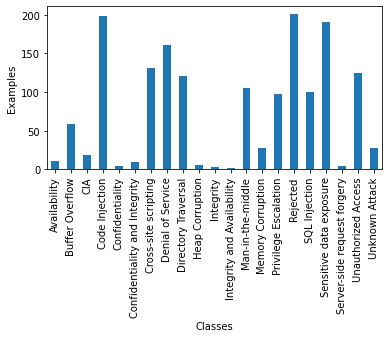

Classes: 21 -> ['Availability' 'Buffer Overflow' 'CIA' 'Code Injection' 'Confidentiality'
 'Confidentiality and Integrity' 'Cross-site scripting'
 'Denial of Service' 'Directory Traversal' 'Heap Corruption' 'Integrity'
 'Integrity and Availability' 'Man-in-the-middle' 'Memory Corruption'
 'Privilege Escalation' 'Rejected' 'Sensitive data exposure'
 'Server-side request forgery' 'SQL Injection' 'Unauthorized Access'
 'Unknown Attack']


In [14]:
# Check Imbalanced Classes
fig = plt.figure(figsize=(6,3))
df_labeled_data.groupby('Predicted Label').Label_id.count().plot.bar(ylim=0)
plt.xlabel("Classes")
plt.ylabel("Examples")
plt.show() 

# labels = list(df_labeled_data['Predicted Label'].unique()) # Take unique labels
print('Classes:', len(df_labeled_data['Predicted Label'].unique()), '->', df_labeled_data['Predicted Label'].unique())

In [15]:
# Convert descriptions column into a list
descriptions_list = df_labeled_data['description'].to_list()
descriptions_list = [x.lower() for x in descriptions_list] # lower case descriptions

# descriptions_list = descriptions_list[501:1000]

In [16]:
print('Total descriptions:', len(descriptions_list))
print('Max length:', len(max(descriptions_list, key=len)))
print('Average length:', round((float(sum([len(ele) for ele in descriptions_list])) / len(descriptions_list)),2))
print('Over 1000:', len([item for item in descriptions_list if len(item) > 10]))

Total descriptions: 1600
Max length: 3819
Average length: 283.6
Over 1000: 1600


In [17]:
import time
start = time.time()

bert_labels = []
for desc in descriptions_list:
  if len(desc) >= 1000: desc = desc[0:999]

  inputs = tokenizer.batch_encode_plus([desc] + labels, return_tensors='pt', padding='longest') # padding=True, pad_to_max_length=True, padding=True, padding='longest', padding='max_length'
  input_ids = inputs['input_ids']
  attention_mask = inputs['attention_mask']
  output = model(input_ids, attention_mask=attention_mask)[0]
  desc_rep = output[:1].mean(dim=1)
  label_reps = output[1:].mean(dim=1)

  # now find the labels with the highest cosine similarities to the desc
  similarities = F.cosine_similarity(desc_rep, label_reps)
  closest = similarities.argsort(descending=True)

  bert_labels.append({'Description': desc, 'Bert_Label': labels[np.argmax(similarities.cpu().detach().numpy())], 'Bert_Con': round(similarities[np.argmax(similarities.cpu().detach().numpy())].item(), 2)})

zero_shot_bert_df = pd.DataFrame(bert_labels) 
print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

zero_shot_bert_df

Elapsed time = 1219.6716 secs


,Description,Bert_Label,Bert_Con
0,"Unspecified vulnerability in Oracle Solaris 9,...",Unauthorized Access,0.41
1,Unspecified vulnerability in Oracle MySQL Serv...,Web Session Cookie,0.48
2,Unspecified vulnerability in Oracle Solaris 11...,Spyware,0.46
3,Unspecified vulnerability in the MySQL Server ...,Disabling Security Tools,0.45
4,Unspecified vulnerability in the JD Edwards En...,Disabling Security Tools,0.45
...,...,...,...
1595,Unspecified vulnerability in MoinMoin 1.5.x th...,System Misconfiguration,0.44
1596,Multiple buffer overflows in PostgreSQL before...,Disabling Security Tools,0.47
1597,The image gallery (imagegallery) component in ...,Drive-by Download Attack,0.44
1598,A certain contributed script for ekg Gadu Gadu...,Web Session Cookie,0.50


In [18]:
# Add the new labels to the dataframe
df_labeled_data['Bert_Label'] = zero_shot_bert_df['Bert_Label'] # IF not classifying all labels, modify df_labeled_data to add only limited labels!
df_labeled_data.head()
# df_labeled_data.iloc[15:25]

,_id,description,Predicted Label,Label_id,Bert_Label
0,CVE-2012-0563,"Unspecified vulnerability in Oracle Solaris 9,...",Availability,0,Unauthorized Access
1,CVE-2015-0433,Unspecified vulnerability in Oracle MySQL Serv...,Availability,0,Web Session Cookie
2,CVE-2011-3543,Unspecified vulnerability in Oracle Solaris 11...,Availability,0,Spyware
3,CVE-2014-0386,Unspecified vulnerability in the MySQL Server ...,Availability,0,Disabling Security Tools
4,CVE-2016-0422,Unspecified vulnerability in the JD Edwards En...,Availability,0,Disabling Security Tools


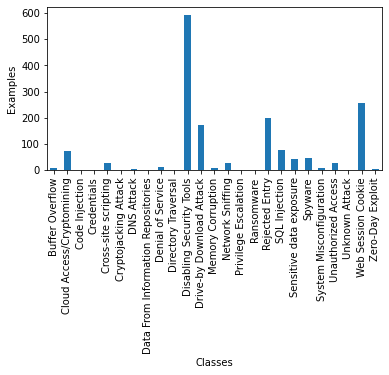

Classes: 25 -> ['Unauthorized Access' 'Web Session Cookie' 'Spyware'
 'Disabling Security Tools' 'Buffer Overflow' 'Drive-by Download Attack'
 'SQL Injection' 'Cloud Access/Cryptomining' 'Sensitive data exposure'
 'Network Sniffing' 'Memory Corruption' 'System Misconfiguration'
 'Cryptojacking Attack' 'Cross-site scripting' 'Code Injection'
 'Directory Traversal' 'Denial of Service' 'DNS Attack'
 'Privilege Escalation' 'Zero-Day Exploit' 'Rejected Entry' 'Credentials'
 'Data From Information Repositories' 'Ransomware' 'Unknown Attack']


In [19]:
# Check Imbalanced Classes
fig = plt.figure(figsize=(6,3))
df_labeled_data.groupby('Bert_Label').Label_id.count().plot.bar(ylim=0)
plt.xlabel("Classes")
plt.ylabel("Examples")
plt.show() 

print('Classes:', len(df_labeled_data['Bert_Label'].unique()), '->', df_labeled_data['Bert_Label'].unique())

In [20]:
# Export new labels data
df_labeled_data.to_csv(dataset_path+'new_labels_Bert.csv')

In [21]:
print('Label counts:')
print(df_labeled_data['Predicted Label'].value_counts())
print('**********************************')
print(df_labeled_data['Bert_Label'].value_counts())

Label counts:
Rejected                         201
Code Injection                   198
Sensitive data exposure          190
Denial of Service                161
Cross-site scripting             131
Unauthorized Access              124
Directory Traversal              121
Man-in-the-middle                105
SQL Injection                    100
Privilege Escalation              98
Buffer Overflow                   58
Memory Corruption                 28
Unknown Attack                    27
CIA                               19
Availability                      11
Confidentiality and Integrity     10
Heap Corruption                    5
Server-side request forgery        4
Confidentiality                    4
Integrity                          3
Integrity and Availability         2
Name: Predicted Label, dtype: int64
**********************************
Disabling Security Tools              593
Web Session Cookie                    258
Rejected Entry                        199
Drive-by Dow

[[ 0  0  0 ...  0  3  0]
 [ 0 10  0 ...  0 21  0]
 [ 0  0  0 ...  0  5  0]
 ...
 [ 0  0  0 ...  1  6  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


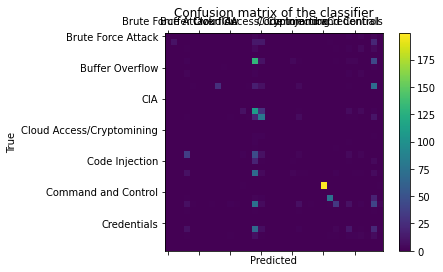

Accuracy = 0.0988


In [22]:
# BERT https://medium.com/analytics-vidhya/multiclass-text-categorization-97-perc-accuracy-bert-model-2b97d8118903
# https://towardsdatascience.com/how-i-achieved-90-accuracy-on-a-text-classification-problem-with-zero-preprocessing-6acfa96e8d2e

# Test Accuracy
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

y_test = df_labeled_data['Predicted Label'].tolist()
y_pred = df_labeled_data['Bert_Label'].tolist()

cm = confusion_matrix(y_test, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print('Accuracy = {:6.4f}'.format(accuracy_score(y_test, y_pred)))

## Method 2 - Flair

https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_10_TRAINING_ZERO_SHOT_MODEL.md

### Load Model

In [23]:
!pip install flair
from flair.models import TARSClassifier
from flair.data import Sentence

# 1. Load our pre-trained TARS model for English
tars = TARSClassifier.load('tars-base')
# 1. Load zero-shot NER tagger
# tars = TARSTagger.load('tars-ner')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 5.1 MB/s 
     |████████████████████████████████| 788 kB 84.7 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 76.8 MB/s 
     |████████████████████████████████| 1.6 MB 66.8 MB/s 
     |████████████████████████████████| 19.7 MB 69.8 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 981 kB 77.3 MB/s 
     |████████████████████████████████| 200 kB 76.5 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-py3-none-any.whl size=116702 sha256=640fb44c257f2a7925c71cffd455a0e6053dc6a6c358d9466400b04da4137cb6
  Stored in directory: /root/.cache/pip/wheels/26/70/6a/1c79e59951a41b4045497da187b2724f5659ca64033cf4548e
  Created wheel for overrides: filename=overrides-3.1.0-py3-none-any.whl 

2022-09-27 14:43:56,139 https://nlp.informatik.hu-berlin.de/resources/models/tars-base/tars-base-v8.pt not found in cache, downloading to /tmp/tmpojt10zfc


100%|██████████| 438064585/438064585 [00:20<00:00, 21676754.85B/s]

2022-09-27 14:44:16,737 copying /tmp/tmpojt10zfc to cache at /root/.flair/models/tars-base-v8.pt


2022-09-27 14:44:17,293 removing temp file /tmp/tmpojt10zfc
2022-09-27 14:44:17,351 loading file /root/.flair/models/tars-base-v8.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Test Example

In [24]:
# from flair.models import TARSClassifier
# from flair.data import Sentence

# # 1. Load our pre-trained TARS model for English
# tars = TARSClassifier.load('tars-base')

# 2. Prepare a test sentence
sentence = Sentence("I am so glad you liked it!")

# 3. Define some classes that you want to predict using descriptive names
classes = ["happy", "sad"]

#4. Predict for these classes
tars.predict_zero_shot(sentence, classes)

# Print sentence with predicted labels
print(sentence)

Sentence: "I am so glad you liked it !" → happy (0.8667)


In [25]:
from flair.data import Sentence

sentences4 = [
    "The Humboldt University of Berlin is situated near the Spree in Berlin, Germany",
    "Bayern Munich played against Real Madrid",
    "I flew with an Airbus A380 to Peru to pick up my Porsche Cayenne",
    "Game of Thrones is my favorite series"
]

# 3. Define some classes of named entities such as "soccer teams", "TV shows" and "rivers"
labels4 = ["Soccer Team", "University", "Vehicle", "River", "City", "Country", "Person", "Movie", "TV Show"]
tars.add_and_switch_to_new_task('task 1', labels4, label_type='ner')

# 4. Predict for these classes and print results
for s in sentences4:
  # print(type(Sentence(s)))
  t = Sentence(s)
  tars.predict(t)
  try:
    # print(Sentence(s).to_tagged_string("ner").split(";")[0].split(" (")[0].split(" → ")[1])
    print(t.to_tagged_string("ner"))
  except IndexError:
    print('No Label')
    pass

Sentence: "The Humboldt University of Berlin is situated near the Spree in Berlin , Germany" → University (0.9998)
Sentence: "Bayern Munich played against Real Madrid" → Soccer Team (0.989)
Sentence: "I flew with an Airbus A380 to Peru to pick up my Porsche Cayenne"
Sentence: "Game of Thrones is my favorite series" → Movie (0.963); TV Show (0.8084)


### Test Vulnerability Data

In [26]:
# # 2. Prepare some test sentences
# sentences = [
#   Sentence("A certain contributed script for ekg Gadu Gadu client 1.5 and earlier allows attackers to execute shell commands via unknown attack vectors."),
#   Sentence("An issue was discovered in CImg v.220. A double free in load_bmp in CImg.h occurs when loading a crafted bmp image."),
#   Sentence("SQL injection vulnerability in the Facile Forms (com_facileforms) component for Joomla! and Mambo allows remote attackers to execute arbitrary SQL commands via the catid parameter to index.php."),
#   Sentence("The coffescript module exfiltrates sensitive data such as a user's private SSH key and bash history to a third party server during installation."),
#   Sentence("** REJECT **  DO NOT USE THIS CANDIDATE NUMBER. ConsultIDs: none. Reason: The CNA or individual who requested this candidate did not associate it with any vulnerability during 2015. Notes: none."),
#   Sentence("Sophos SafeGuard Enterprise before 8.00.5, SafeGuard Easy before 7.00.3, and SafeGuard LAN Crypt before 3.95.2 are vulnerable to Local Privilege Escalation via multiple IOCTLs, e.g., 0x8810200B, 0x8810200F, 0x8810201B, 0x8810201F, 0x8810202B, 0x8810202F, 0x8810203F, 0x8810204B, 0x88102003, 0x88102007, 0x88102013, 0x88102017, 0x88102027, 0x88102033, 0x88102037, 0x88102043, and 0x88102047. When some conditions in the user-controlled input buffer are not met, the driver writes an error code (0x2000001A) to a user-controlled address. Also, note that all the aforementioned IOCTLs use transfer type METHOD_NEITHER, which means that the I/O manager does not validate any of the supplied pointers and buffer sizes. So, even though the driver checks for input/output buffer sizes, it doesn't validate if the pointers to those buffers are actually valid. So, we can supply a pointer for the output buffer to a kernel address space address, and the error code will be written there. We can take advantage of this condition to modify the SEP_TOKEN_PRIVILEGES structure of the Token object belonging to the exploit process and grant SE_DEBUG_NAME privilege. This allows the exploit process to interact with higher privileged processes running as SYSTEM and execute code in their security context."),
#   Sentence('A remote code execution vulnerability exists when Internet Explorer improperly accesses objects in memory, aka "Internet Explorer Memory Corruption Vulnerability." This affects Internet Explorer 9, Internet Explorer 11, Internet Explorer 10. This CVE ID is unique from CVE-2018-8249.'),
#   Sentence("The Secret Circle - talk freely (aka com.easyxapp.secret) application 2.2.00.26 for Android does not verify X.509 certificates from SSL servers, which allows man-in-the-middle attackers to spoof servers and obtain sensitive information via a crafted certificate."),
#   Sentence("Directory traversal vulnerability in Intervations FileCOPA FTP Server 1.01 allows remote attackers to read and write arbitrary files via a .. (dot dot) in the (1) STOR and (2) RETR commands."),
#   Sentence("Off-by-one buffer overflow in NEC SOCKS5 1.0 r11 and earlier allows remote attackers to cause a denial of service and possibly execute arbitrary code via a long hostname."),
#   Sentence("A stored cross-site scripting vulnerability in Jenkins 2.191 and earlier, LTS 2.176.2 and earlier allowed attackers with Overall/Administer permission to configure the update site URL to inject arbitrary HTML and JavaScript in update center web pages."),
#   Sentence("Vulnerability in the Oracle WebLogic Server product of Oracle Fusion Middleware (component: Core). Supported versions that are affected are 10.3.6.0.0, 12.1.3.0.0, 12.2.1.3.0, 12.2.1.4.0 and 14.1.1.0.0. Easily exploitable vulnerability allows unauthenticated attacker with network access via IIOP, T3 to compromise Oracle WebLogic Server. Successful attacks of this vulnerability can result in takeover of Oracle WebLogic Server. CVSS 3.1 Base Score 9.8 (Confidentiality, Integrity and Availability impacts). CVSS Vector: (CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H)."),
#   Sentence("A heap-based buffer overflow exists in the AP4_StdcFileByteStream::ReadPartial component located in /StdC/Ap4StdCFileByteStream.cpp of Bento4 version 06c39d9. This issue can lead to a denial of service (DOS)."),
#   Sentence("Unspecified vulnerability in Oracle Solaris 9, 10, and 11 allows local users to affect availability via unknown vectors related to Kerberos/klist."),
#   Sentence("Buffer overflow in Solaris libc, ufsrestore, and rcp via LC_MESSAGES environmental variable."),
#   Sentence("The command ipfilter in Brocade Fabric OS before Brocade Fabric OS v.9.0.1a, v8.2.3, and v8.2.0_CBN4, and v7.4.2h uses unsafe string function to process user input. Authenticated attackers can abuse this vulnerability to exploit stack-based buffer overflows, allowing execution of arbitrary code as the root user account."),
#   Sentence("Multiple command injection vulnerabilities in NeDi before 1.7Cp3 allow authenticated users to execute code on the server side via the flt parameter to Nodes-Traffic.php, the dv parameter to Devices-Graph.php, or the tit parameter to drawmap.php."),
#   Sentence("Cross-site scripting (XSS) vulnerability in the MT4i plugin 3.1 beta 4 and earlier for Movable Type allows remote attackers to inject arbitrary web script or HTML via unspecified vectors, a different vulnerability than CVE-2012-2642."),
# ]

# # 3. Define some classes of named entities such as "soccer teams", "TV shows" and "rivers"
# labels = ['Brute Force Attack', 'Buffer Overflow', 'CIA', 'Cloud Access/Cryptomining', 'Code Injection', 'Command and Control', 'Credentials', 'Cross-site scripting', 'Cryptojacking Attack', 'Data From Information Repositories', 'Denial of Service', 'Directory Traversal', 'Disabling Security Tools', 'DNS Attack', 'Drive-by Download Attack', 'Host Redirection', 'Insider Threat', 'IoT Threat', 'Macro Viruses', 'Malicious Powershell', 'Man-in-the-middle', 'Masquerade Attack', 'Meltdown and Spectre Attack', 'Memory Corruption', 'Network Sniffing', 'Pass the Hash', 'Phishing', 'Privilege Escalation', 'Ransomware', 'Rejected Entry', 'Sensitive data exposure', 'Shadow ITSIM jacking', 'Social Engineering Attack', 'Spyware', 'SQL Injection', 'System Misconfiguration', 'Typosquatting', 'Unauthorized Access', 'Unknown Attack', 'Watering Hole Attack', 'Web Session Cookie', 'Wire Attack', 'Zero-Day Exploit'] 

# print('Total labels:', len(labels))

# tars.add_and_switch_to_new_task('task 1', labels, label_type='ner')

# # 4. Predict for these classes and print results
# for sentence in sentences:
#   print(type(sentence))
#   tars.predict(sentence)
#   print((sentence.to_tagged_string("ner")).split(";")[0])
#   # print((sentence.to_tagged_string("ner")).split(";")[0].split(" (")[0])

### Check Labeled data

In [35]:
tars.add_and_switch_to_new_task('task 2', labels, label_type='ner')

flair_labels = []
for desc in descriptions_list:
  if len(desc) >= 1000: desc = desc[0:999]

  s = Sentence(desc)
  tars.predict(s)
  try:
    # print(desc)
    # print(s.to_tagged_string("ner").split(";")[0].split(" (")[0].split(" → ")[1])
    flair_labels.append(s.to_tagged_string("ner").split(";")[0].split(" (")[0].split(" → ")[1])
  except IndexError:
    print(desc)
    print('No Label')
    flair_labels.append('No Label')
    pass

2022-09-27 15:26:23,335 Task `task 2` already exists in TARS model. Switching to it.
unspecified vulnerability in oracle solaris 11 express allows remote attackers to affect availability, related to iscsi datamover (idm).
No Label
a heap-based buffer overflow exists in the ap4_stdcfilebytestream::readpartial component located in /stdc/ap4stdcfilebytestream.cpp of bento4 version 06c39d9. this issue can lead to a denial of service (dos).
No Label
stack-based buffer overflow in ibm informix dynamic server (ids) 7.x through 7.31, 9.x through 9.40, 10.00 before 10.00.xc10, 11.10 before 11.10.xc3, and 11.50 before 11.50.xc3 allows remote authenticated users to execute arbitrary code via long dbinfo keyword arguments in a sql statement, aka idsdb00165017, idsdb00165019, idsdb00165021, idsdb00165022, and idsdb00165023.
No Label
buffer overflow in uucp in compaq tru64/osf1 3.x allows local users to execute arbitrary code via a long source (-s) command line parameter.
No Label
the minttoken func

In [36]:
# Add the new labels to the dataframe
df_labeled_data['Flair_Label'] = flair_labels
df_labeled_data.head()
# df_labeled_data.iloc[15:25]

,_id,description,Predicted Label,Label_id,Bert_Label,Flair_Label
0,CVE-2012-0563,"Unspecified vulnerability in Oracle Solaris 9,...",Availability,0,Unauthorized Access,Code Injection
1,CVE-2015-0433,Unspecified vulnerability in Oracle MySQL Serv...,Availability,0,Web Session Cookie,Code Injection
2,CVE-2011-3543,Unspecified vulnerability in Oracle Solaris 11...,Availability,0,Spyware,No Label
3,CVE-2014-0386,Unspecified vulnerability in the MySQL Server ...,Availability,0,Disabling Security Tools,Code Injection
4,CVE-2016-0422,Unspecified vulnerability in the JD Edwards En...,Availability,0,Disabling Security Tools,Code Injection


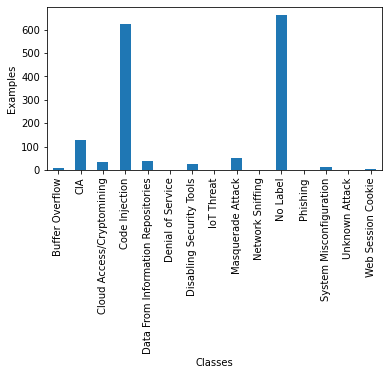

Classes: 15 -> ['Code Injection' 'No Label' 'System Misconfiguration' 'Buffer Overflow'
 'Unknown Attack' 'Cloud Access/Cryptomining' 'Denial of Service' 'CIA'
 'Data From Information Repositories' 'Web Session Cookie'
 'Disabling Security Tools' 'Masquerade Attack' 'Phishing' 'IoT Threat'
 'Network Sniffing']


In [37]:
# Check Imbalanced Classes
fig = plt.figure(figsize=(6,3))
df_labeled_data.groupby('Flair_Label').Label_id.count().plot.bar(ylim=0)
plt.xlabel("Classes")
plt.ylabel("Examples")
plt.show() 

print('Classes:', len(df_labeled_data['Flair_Label'].unique()), '->', df_labeled_data['Flair_Label'].unique())

In [38]:
print('Label counts:')
print(df_labeled_data['Predicted Label'].value_counts())
print('**********************************')
print(df_labeled_data['Bert_Label'].value_counts())
print('**********************************')
print(df_labeled_data['Flair_Label'].value_counts())

Label counts:
Rejected                         201
Code Injection                   198
Sensitive data exposure          190
Denial of Service                161
Cross-site scripting             131
Unauthorized Access              124
Directory Traversal              121
Man-in-the-middle                105
SQL Injection                    100
Privilege Escalation              98
Buffer Overflow                   58
Memory Corruption                 28
Unknown Attack                    27
CIA                               19
Availability                      11
Confidentiality and Integrity     10
Heap Corruption                    5
Server-side request forgery        4
Confidentiality                    4
Integrity                          3
Integrity and Availability         2
Name: Predicted Label, dtype: int64
**********************************
Disabling Security Tools              593
Web Session Cookie                    258
Rejected Entry                        199
Drive-by Dow

In [39]:
# Export new labels data
df_labeled_data.to_csv(dataset_path+'new_labels_Flair.csv')

## Method 3 - Transformers

#### Install

In [40]:
!pip install transformers
# https://analyticsindiamag.com/a-complete-tutorial-on-zero-shot-text-classification/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Load Model - Bart Large

In [41]:
import transformers
bl_classifier = transformers.pipeline('zero-shot-classification', model='facebook/bart-large-mnli')

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

#### Example

In [42]:
# sequence1="i can perform article" 

# labels1 = ['writting', 'management', 'checking']

# res = classifier(sequence1, labels1)

# # Get max score index
# max_score_index = res['scores'].index(max(res['scores']))

# print(res['sequence'], '->', res['labels'][max_score_index], '->', round(res['scores'][max_score_index], 2))

# res

#### Bart Classification

In [43]:
# labels = ['Brute Force Attack', 'Buffer Overflow', 'CIA', 'Cloud Access/Cryptomining', 'Code Injection', 'Command and Control', 'Credentials', 'Cross-site scripting', 'Cryptojacking Attack', 'Data From Information Repositories', 'Denial of Service', 'Directory Traversal', 'Disabling Security Tools', 'DNS Attack', 'Drive-by Download Attack', 'Host Redirection', 'Insider Threat', 'IoT Threat', 'Macro Viruses', 'Malicious Powershell', 'Man-in-the-middle', 'Masquerade Attack', 'Meltdown and Spectre Attack', 'Memory Corruption', 'Network Sniffing', 'Pass the Hash', 'Phishing', 'Privilege Escalation', 'Ransomware', 'Rejected Entry', 'Sensitive data exposure', 'Shadow ITSIM jacking', 'Social Engineering Attack', 'Spyware', 'SQL Injection', 'System Misconfiguration', 'Typosquatting', 'Unauthorized Access', 'Unknown Attack', 'Watering Hole Attack', 'Web Session Cookie', 'Wire Attack', 'Zero-Day Exploit'] 
len(labels)

43

In [45]:
import time
start = time.time()

bl_labels = []

for desc in descriptions_list:
  if len(desc) >= 1000: desc = desc[0:999]

  res = bl_classifier(desc, labels)

  # print(res['sequence'], '\n', res['labels'][max_score_index], '->', round(res['scores'][max_score_index], 2), '\n') 
  max_score_index = res['scores'].index(max(res['scores']))
  bl_labels.append({'Description': desc, 'BL_Label': res['labels'][max_score_index], 'BL_Con': round(res['scores'][max_score_index], 2)})

zero_shot_bl_df = pd.DataFrame(bl_labels)
print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

zero_shot_bl_df

Elapsed time = 9185.6525 secs


,Description,BL_Label,BL_Con
0,"Unspecified vulnerability in Oracle Solaris 9,...",unknown attack,0.64
1,Unspecified vulnerability in Oracle MySQL Serv...,unknown attack,0.63
2,Unspecified vulnerability in Oracle Solaris 11...,unknown attack,0.60
3,Unspecified vulnerability in the MySQL Server ...,unknown attack,0.55
4,Unspecified vulnerability in the JD Edwards En...,unknown attack,0.66
...,...,...,...
1595,Unspecified vulnerability in MoinMoin 1.5.x th...,unknown attack,0.55
1596,Multiple buffer overflows in PostgreSQL before...,buffer overflow,0.44
1597,The image gallery (imagegallery) component in ...,unknown attack,0.51
1598,A certain contributed script for ekg Gadu Gadu...,unknown attack,0.63


In [46]:
# Add the new labels to the dataframe
df_labeled_data['BL_Label'] = zero_shot_bl_df['BL_Label'] # IF not classifying all labels, modify df_labeled_data to add only limited labels!
df_labeled_data.head()
# df_labeled_data.iloc[15:25]

,_id,description,Predicted Label,Label_id,Bert_Label,Flair_Label,BL_Label
0,CVE-2012-0563,"Unspecified vulnerability in Oracle Solaris 9,...",Availability,0,Unauthorized Access,Code Injection,unknown attack
1,CVE-2015-0433,Unspecified vulnerability in Oracle MySQL Serv...,Availability,0,Web Session Cookie,Code Injection,unknown attack
2,CVE-2011-3543,Unspecified vulnerability in Oracle Solaris 11...,Availability,0,Spyware,No Label,unknown attack
3,CVE-2014-0386,Unspecified vulnerability in the MySQL Server ...,Availability,0,Disabling Security Tools,Code Injection,unknown attack
4,CVE-2016-0422,Unspecified vulnerability in the JD Edwards En...,Availability,0,Disabling Security Tools,Code Injection,unknown attack


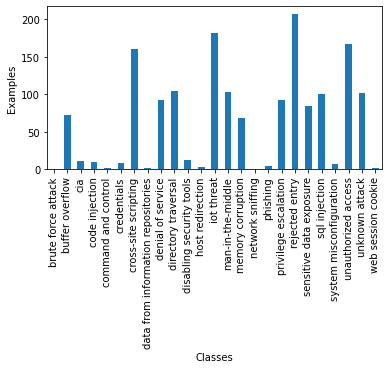

Classes: 25 -> ['unknown attack' 'privilege escalation' 'buffer overflow'
 'unauthorized access' 'denial of service' 'iot threat' 'code injection'
 'sensitive data exposure' 'credentials' 'cross-site scripting'
 'memory corruption' 'directory traversal' 'disabling security tools'
 'system misconfiguration' 'data from information repositories' 'cia'
 'rejected entry' 'phishing' 'man-in-the-middle' 'sql injection'
 'network sniffing' 'command and control' 'brute force attack'
 'host redirection' 'web session cookie']


In [47]:
# Check Imbalanced Classes
fig = plt.figure(figsize=(6,3))
df_labeled_data.groupby('BL_Label').Label_id.count().plot.bar(ylim=0)
plt.xlabel("Classes")
plt.ylabel("Examples")
plt.show() 

print('Classes:', len(df_labeled_data['BL_Label'].unique()), '->', df_labeled_data['BL_Label'].unique())

In [48]:
print('Label counts:')
print(df_labeled_data['Predicted Label'].value_counts())
print('**********************************')
print(df_labeled_data['Bert_Label'].value_counts())
print('**********************************')
print(df_labeled_data['Flair_Label'].value_counts())
print('**********************************')
print(df_labeled_data['BL_Label'].value_counts())

Label counts:
Rejected                         201
Code Injection                   198
Sensitive data exposure          190
Denial of Service                161
Cross-site scripting             131
Unauthorized Access              124
Directory Traversal              121
Man-in-the-middle                105
SQL Injection                    100
Privilege Escalation              98
Buffer Overflow                   58
Memory Corruption                 28
Unknown Attack                    27
CIA                               19
Availability                      11
Confidentiality and Integrity     10
Heap Corruption                    5
Server-side request forgery        4
Confidentiality                    4
Integrity                          3
Integrity and Availability         2
Name: Predicted Label, dtype: int64
**********************************
Disabling Security Tools              593
Web Session Cookie                    258
Rejected Entry                        199
Drive-by Dow

In [49]:
df_labeled_data.to_csv(dataset_path+'zero_shot_labels_BL.csv')

#### Cross-Encoder for Natural Language Inference

In [50]:
# Cross-Encoder for Natural Language Inference
# This transformer is also a part of the hugging face transformer family that is trained using the SNLI and MNLI datasets. It can be utilized for cross encoding and zero-shot text classification.
ce_classifier = transformers.pipeline('zero-shot-classification', model='cross-encoder/nli-distilroberta-base')

Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

#### Example

In [51]:
# sequence2="i can perform article" 
# labels2 = ['writting', 'management', 'checking']
# ce_classifier(sequence2, labels2)

#### Cross-Encoder Classification

In [52]:
# Vulneraiblity DAta Test
start = time.time()

ce_labels = []

for desc in descriptions_list:
  if len(desc) >= 1000: desc = desc[0:999]
  
  res = ce_classifier(desc, labels)
  # print(res['sequence'], '\n', res['labels'][max_score_index], '->', round(res['scores'][max_score_index], 2), '\n') 
  max_score_index = res['scores'].index(max(res['scores']))
  ce_labels.append({'Description': desc, 'CE_Label': res['labels'][max_score_index], 'CE_Con': round(res['scores'][max_score_index], 2)})

zero_shot_nli_df = pd.DataFrame(ce_labels)
print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

zero_shot_nli_df

Elapsed time = 1304.1421 secs


,Description,CE_Label,CE_Con
0,"Unspecified vulnerability in Oracle Solaris 9,...",unknown attack,0.13
1,Unspecified vulnerability in Oracle MySQL Serv...,sensitive data exposure,0.10
2,Unspecified vulnerability in Oracle Solaris 11...,unknown attack,0.34
3,Unspecified vulnerability in the MySQL Server ...,unknown attack,0.10
4,Unspecified vulnerability in the JD Edwards En...,unknown attack,0.27
...,...,...,...
1595,Unspecified vulnerability in MoinMoin 1.5.x th...,unknown attack,0.22
1596,Multiple buffer overflows in PostgreSQL before...,buffer overflow,0.50
1597,The image gallery (imagegallery) component in ...,code injection,0.10
1598,A certain contributed script for ekg Gadu Gadu...,unknown attack,0.19


In [53]:
# Add the new labels to the dataframe
df_labeled_data['CE_Label'] = zero_shot_nli_df['CE_Label'] # IF not classifying all labels, modify df_labeled_data to add only limited labels!
df_labeled_data.head()
# df_labeled_data.iloc[15:25]

,_id,description,Predicted Label,Label_id,Bert_Label,Flair_Label,BL_Label,CE_Label
0,CVE-2012-0563,"Unspecified vulnerability in Oracle Solaris 9,...",Availability,0,Unauthorized Access,Code Injection,unknown attack,unknown attack
1,CVE-2015-0433,Unspecified vulnerability in Oracle MySQL Serv...,Availability,0,Web Session Cookie,Code Injection,unknown attack,sensitive data exposure
2,CVE-2011-3543,Unspecified vulnerability in Oracle Solaris 11...,Availability,0,Spyware,No Label,unknown attack,unknown attack
3,CVE-2014-0386,Unspecified vulnerability in the MySQL Server ...,Availability,0,Disabling Security Tools,Code Injection,unknown attack,unknown attack
4,CVE-2016-0422,Unspecified vulnerability in the JD Edwards En...,Availability,0,Disabling Security Tools,Code Injection,unknown attack,unknown attack


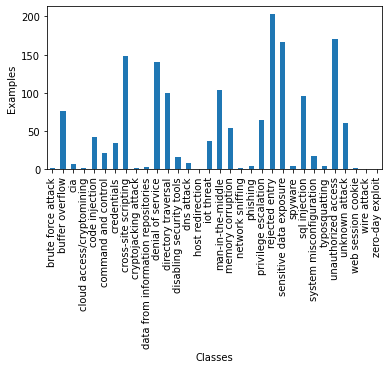

Classes: 32 -> ['unknown attack' 'sensitive data exposure' 'buffer overflow'
 'unauthorized access' 'denial of service' 'spyware' 'code injection'
 'zero-day exploit' 'command and control' 'memory corruption' 'iot threat'
 'credentials' 'disabling security tools' 'cross-site scripting'
 'system misconfiguration' 'directory traversal' 'dns attack'
 'cryptojacking attack' 'cia' 'typosquatting' 'wire attack' 'phishing'
 'man-in-the-middle' 'privilege escalation'
 'data from information repositories' 'rejected entry' 'sql injection'
 'cloud access/cryptomining' 'network sniffing' 'brute force attack'
 'host redirection' 'web session cookie']


In [54]:
# Check Imbalanced Classes
fig = plt.figure(figsize=(6,3))
df_labeled_data.groupby('CE_Label').Label_id.count().plot.bar(ylim=0)
plt.xlabel("Classes")
plt.ylabel("Examples")
plt.show() 

print('Classes:', len(df_labeled_data['CE_Label'].unique()), '->', df_labeled_data['CE_Label'].unique())

In [55]:
print('Label counts:')
print(df_labeled_data['Predicted Label'].value_counts())
print('**********************************')
print(df_labeled_data['Bert_Label'].value_counts())
print('**********************************')
print(df_labeled_data['Flair_Label'].value_counts())
print('**********************************')
print(df_labeled_data['BL_Label'].value_counts())
print('**********************************')
print(df_labeled_data['CE_Label'].value_counts())

Label counts:
Rejected                         201
Code Injection                   198
Sensitive data exposure          190
Denial of Service                161
Cross-site scripting             131
Unauthorized Access              124
Directory Traversal              121
Man-in-the-middle                105
SQL Injection                    100
Privilege Escalation              98
Buffer Overflow                   58
Memory Corruption                 28
Unknown Attack                    27
CIA                               19
Availability                      11
Confidentiality and Integrity     10
Heap Corruption                    5
Server-side request forgery        4
Confidentiality                    4
Integrity                          3
Integrity and Availability         2
Name: Predicted Label, dtype: int64
**********************************
Disabling Security Tools              593
Web Session Cookie                    258
Rejected Entry                        199
Drive-by Dow

In [56]:
df_labeled_data.to_csv(dataset_path+'zero_shot_labels_CE.csv')

#### Bart large model for NLI-based Zero Shot Text Classification

In [57]:
# Bart-large-nli
# This model is trained using the NLI dataset. This one is specially designed for zero-shot text classification. The base transformer for this model is bart-large. Let’s try this model.
import time
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# Load model & tokenizer
bart_model = AutoModelForSequenceClassification.from_pretrained('navteca/bart-large-mnli')
bart_tokenizer = AutoTokenizer.from_pretrained('navteca/bart-large-mnli')

# Get predictions
nlp = pipeline('zero-shot-classification', model=bart_model, tokenizer=bart_tokenizer)

Downloading:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/32.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

#### Example

In [58]:
# sequence3="i can perform article" 

# labels3 = ['writting', 'management', 'checking']

# res = nlp(sequence3, labels3)
# print(res['sequence'], '->', res['labels'][max_score_index], '->', round(res['scores'][max_score_index], 2))

#### Bart large model for NLI-based Zero Shot Text Classification

In [59]:
# Vulneraiblity DAta Test
start = time.time()

bltc_labels = []

for desc in descriptions_list:
  if len(desc) >= 1000: desc = desc[0:999]

  res = nlp(desc, labels)
  # print(res['sequence'], '\n', res['labels'][max_score_index], '->', round(res['scores'][max_score_index], 2), '\n') 
  max_score_index = res['scores'].index(max(res['scores']))
  bltc_labels.append({'Description': res['sequence'], 'BLTC_Label': res['labels'][max_score_index], 'BLTC_Con': round(res['scores'][max_score_index], 2)})

zero_shot_bltc_df = pd.DataFrame(bltc_labels)
print('Elapsed time = {:.4f} secs'.format(time.time() - start)) 

zero_shot_bltc_df

Elapsed time = 9363.3996 secs


,Description,BLTC_Label,BLTC_Con
0,"Unspecified vulnerability in Oracle Solaris 9,...",unknown attack,0.64
1,Unspecified vulnerability in Oracle MySQL Serv...,unknown attack,0.63
2,Unspecified vulnerability in Oracle Solaris 11...,unknown attack,0.60
3,Unspecified vulnerability in the MySQL Server ...,unknown attack,0.55
4,Unspecified vulnerability in the JD Edwards En...,unknown attack,0.66
...,...,...,...
1595,Unspecified vulnerability in MoinMoin 1.5.x th...,unknown attack,0.55
1596,Multiple buffer overflows in PostgreSQL before...,buffer overflow,0.44
1597,The image gallery (imagegallery) component in ...,unknown attack,0.51
1598,A certain contributed script for ekg Gadu Gadu...,unknown attack,0.63


In [60]:
# Add the new labels to the dataframe
df_labeled_data['BLTC_Label'] = zero_shot_bltc_df['BLTC_Label'] # IF not classifying all labels, modify df_labeled_data to add only limited labels!
df_labeled_data.head()
# df_labeled_data.iloc[15:25]

,_id,description,Predicted Label,Label_id,Bert_Label,Flair_Label,BL_Label,CE_Label,BLTC_Label
0,CVE-2012-0563,"Unspecified vulnerability in Oracle Solaris 9,...",Availability,0,Unauthorized Access,Code Injection,unknown attack,unknown attack,unknown attack
1,CVE-2015-0433,Unspecified vulnerability in Oracle MySQL Serv...,Availability,0,Web Session Cookie,Code Injection,unknown attack,sensitive data exposure,unknown attack
2,CVE-2011-3543,Unspecified vulnerability in Oracle Solaris 11...,Availability,0,Spyware,No Label,unknown attack,unknown attack,unknown attack
3,CVE-2014-0386,Unspecified vulnerability in the MySQL Server ...,Availability,0,Disabling Security Tools,Code Injection,unknown attack,unknown attack,unknown attack
4,CVE-2016-0422,Unspecified vulnerability in the JD Edwards En...,Availability,0,Disabling Security Tools,Code Injection,unknown attack,unknown attack,unknown attack


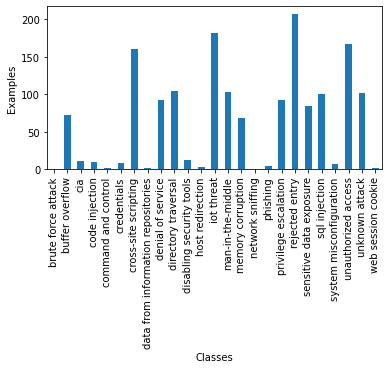

Classes: 25 -> ['unknown attack' 'privilege escalation' 'buffer overflow'
 'unauthorized access' 'denial of service' 'iot threat' 'code injection'
 'sensitive data exposure' 'credentials' 'cross-site scripting'
 'memory corruption' 'directory traversal' 'disabling security tools'
 'system misconfiguration' 'data from information repositories' 'cia'
 'rejected entry' 'phishing' 'man-in-the-middle' 'sql injection'
 'network sniffing' 'command and control' 'brute force attack'
 'host redirection' 'web session cookie']


In [61]:
# Check Imbalanced Classes
fig = plt.figure(figsize=(6,3))
df_labeled_data.groupby('BLTC_Label').Label_id.count().plot.bar(ylim=0)
plt.xlabel("Classes")
plt.ylabel("Examples")
plt.show() 

print('Classes:', len(df_labeled_data['BLTC_Label'].unique()), '->', df_labeled_data['BLTC_Label'].unique())

In [62]:
print('Label counts:')
print(df_labeled_data['Predicted Label'].value_counts())
print('**********************************')
print(df_labeled_data['Bert_Label'].value_counts())
print('**********************************')
print(df_labeled_data['Flair_Label'].value_counts())
print('**********************************')
print(df_labeled_data['BL_Label'].value_counts())
print('**********************************')
print(df_labeled_data['CE_Label'].value_counts())
print('**********************************')
print(df_labeled_data['BLTC_Label'].value_counts())

Label counts:
Rejected                         201
Code Injection                   198
Sensitive data exposure          190
Denial of Service                161
Cross-site scripting             131
Unauthorized Access              124
Directory Traversal              121
Man-in-the-middle                105
SQL Injection                    100
Privilege Escalation              98
Buffer Overflow                   58
Memory Corruption                 28
Unknown Attack                    27
CIA                               19
Availability                      11
Confidentiality and Integrity     10
Heap Corruption                    5
Server-side request forgery        4
Confidentiality                    4
Integrity                          3
Integrity and Availability         2
Name: Predicted Label, dtype: int64
**********************************
Disabling Security Tools              593
Web Session Cookie                    258
Rejected Entry                        199
Drive-by Dow

In [63]:
# # Export new labels data
df_labeled_data.to_csv(dataset_path+'zero_shot_labels_BLTC.csv')

In [64]:
df_labeled_data.to_csv(dataset_path+'zero_shot_labels.csv')

## Zero-shot Label Sampling

### Load Data File

In [65]:
# Mount google drive
import pandas as pd
from google.colab import drive
drive.mount("/content/drive")

# attach files from google drive
dataset_path = '/content/drive/MyDrive/Datasets/'

df_labeled_data = pd.read_csv(dataset_path + 'zero_shot_labels.csv') # 
df_labeled_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,_id,description,Predicted Label,Label_id,Bert_Label,Flair_Label,BL_Label,CE_Label,BLTC_Label
0,0,CVE-2012-0563,"Unspecified vulnerability in Oracle Solaris 9,...",Availability,0,Unauthorized Access,Code Injection,unknown attack,unknown attack,unknown attack
1,1,CVE-2015-0433,Unspecified vulnerability in Oracle MySQL Serv...,Availability,0,Web Session Cookie,Code Injection,unknown attack,sensitive data exposure,unknown attack
2,2,CVE-2011-3543,Unspecified vulnerability in Oracle Solaris 11...,Availability,0,Spyware,No Label,unknown attack,unknown attack,unknown attack
3,3,CVE-2014-0386,Unspecified vulnerability in the MySQL Server ...,Availability,0,Disabling Security Tools,Code Injection,unknown attack,unknown attack,unknown attack
4,4,CVE-2016-0422,Unspecified vulnerability in the JD Edwards En...,Availability,0,Disabling Security Tools,Code Injection,unknown attack,unknown attack,unknown attack


### Sample data

In [66]:
df_labeled_data['Final_Label'] = df_labeled_data.mode(axis = 1)[0] # take most repeating label as final
df_labeled_data = df_labeled_data.drop(['Label_id'], axis=1) # drop label id 
df_labeled_data

,Unnamed: 0,_id,description,Predicted Label,Bert_Label,Flair_Label,BL_Label,CE_Label,BLTC_Label,Final_Label
0,0,CVE-2012-0563,"Unspecified vulnerability in Oracle Solaris 9,...",Availability,Unauthorized Access,Code Injection,unknown attack,unknown attack,unknown attack,unknown attack
1,1,CVE-2015-0433,Unspecified vulnerability in Oracle MySQL Serv...,Availability,Web Session Cookie,Code Injection,unknown attack,sensitive data exposure,unknown attack,unknown attack
2,2,CVE-2011-3543,Unspecified vulnerability in Oracle Solaris 11...,Availability,Spyware,No Label,unknown attack,unknown attack,unknown attack,unknown attack
3,3,CVE-2014-0386,Unspecified vulnerability in the MySQL Server ...,Availability,Disabling Security Tools,Code Injection,unknown attack,unknown attack,unknown attack,unknown attack
4,4,CVE-2016-0422,Unspecified vulnerability in the JD Edwards En...,Availability,Disabling Security Tools,Code Injection,unknown attack,unknown attack,unknown attack,unknown attack
...,...,...,...,...,...,...,...,...,...,...
1595,1595,CVE-2010-0668,Unspecified vulnerability in MoinMoin 1.5.x th...,Unknown Attack,System Misconfiguration,Buffer Overflow,unknown attack,unknown attack,unknown attack,unknown attack
1596,1596,CVE-2014-0065,Multiple buffer overflows in PostgreSQL before...,Unknown Attack,Disabling Security Tools,Code Injection,buffer overflow,buffer overflow,buffer overflow,buffer overflow
1597,1597,CVE-2005-3764,The image gallery (imagegallery) component in ...,Unknown Attack,Drive-by Download Attack,No Label,unknown attack,code injection,unknown attack,unknown attack
1598,1598,CVE-2005-1851,A certain contributed script for ekg Gadu Gadu...,Unknown Attack,Web Session Cookie,Code Injection,unknown attack,unknown attack,unknown attack,unknown attack


In [68]:
df_labeled_data.to_csv(dataset_path+'zero_shot_labels_final.csv')